# Animated graphs

## 1. Metallicity vs age

### 1.1. Data preparation cell

In [1]:
import numpy as np
import pandas as pd
from astroquery.utils.tap.core import TapPlus

# CDS TAP service
tap = TapPlus(url="https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

# В TAP таблица обычно называется с префиксом "J/A+A/685/A66/age_cat"
# ADQL требует экранирования имени таблицы двойными кавычками.
table = '\"J/A+A/685/A66/age_cat\"'

query = f"""
SELECT
  Age, e_Age, "[Fe/H]" AS feh, "e_[Fe/H]" AS e_feh
FROM {table}
"""

job = tap.launch_job_async(query)
t = job.get_results()
df = t.to_pandas()

df_age = (df.rename(columns={"Age":"age", "e_Age":"age_err", "feh":"feh", "e_feh":"feh_err"})
            [["age","age_err","feh","feh_err"]])

for c in df_age.columns:
    df_age[c] = pd.to_numeric(df_age[c], errors="coerce")

df_age = df_age.dropna(subset=["age","feh"]).copy()
df_age = df_age[
    (df_age["age"] > 0) & (df_age["age"] < 14) &
    (df_age["feh"] > -2.0) & (df_age["feh"] < 1.0)
].copy()

print("df_age rows:", len(df_age))
df_age.head()

INFO: Query finished. [astroquery.utils.tap.core]
df_age rows: 125443


age  age_err   feh  feh_err
0   2.40     0.67 -0.12     0.01
1  12.32     2.83 -0.11     0.01
2   6.58     1.37  0.14     0.01
3   4.53     1.00 -0.09     0.01
4   4.74     1.04  0.07     0.01

### 1.2. Use APOGEE Data to create a graph



matplotlib: 3.10.3
Animation format: gif | FPS=24 | DPI=150
Theme: dark
Project root: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab
Topic root:   /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
Animations:   /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
Animating rows: 125443
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif exists: True


PosixPath('/Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_EN_age_feh_boulet.gif')

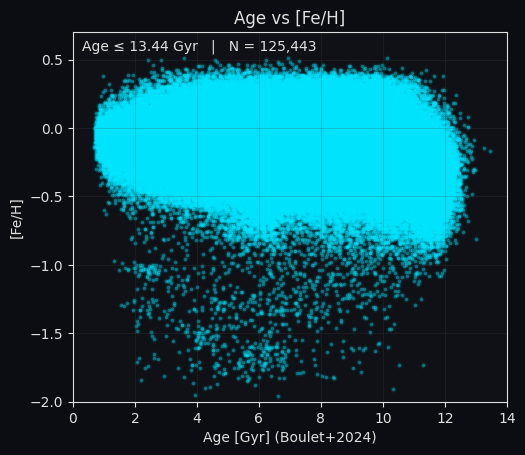

In [2]:
import numpy as np
import matplotlib.animation as animation

from lulab.anim.defaults import apply_theme, THEME, OUT_DIR, FPS, save_animation, print_env
from lulab.anim.plot_helpers import make_fig, set_common_axes, make_corner_text

apply_theme(THEME)
print_env()

# -----------------------------
# 1) Prepare sample (use ALL if <= 200k, else sample)
# -----------------------------
SAMPLE_N = 180_000
samp = df_age.sample(min(len(df_age), SAMPLE_N), random_state=1).copy()
samp = samp.sort_values("age").reset_index(drop=True)

ages = samp["age"].astype(float).to_numpy()
feh  = samp["feh"].astype(float).to_numpy()

print("Animating rows:", len(samp))

# -----------------------------
# 2) Figure styling
# -----------------------------
fig, ax = make_fig(figsize=(5.6, 4.8), grid_alpha=0.22)

set_common_axes(
    ax,
    xlim=(0, 14),
    ylim=(-2.0, 0.7),
    xlabel="Age [Gyr] (Boulet+2024)",
    ylabel="[Fe/H]",
    title="Age vs [Fe/H]"
)

# Bright, high-contrast cyan + glow for dark theme
POINT_COLOR = "#00e5ff"

sc_glow = ax.scatter([], [], s=22, alpha=0.06, c=POINT_COLOR, linewidths=0)
sc      = ax.scatter([], [], s=7,  alpha=0.42, c=POINT_COLOR, linewidths=0)

txt = make_corner_text(ax)
txt.set_text("")

# -----------------------------
# 3) Animation timing
# -----------------------------
DURATION_SEC = 6
N_FRAMES = FPS * DURATION_SEC

age_min, age_max = float(ages.min()), float(ages.max())

def init():
    empty = np.empty((0, 2))
    sc.set_offsets(empty)
    sc_glow.set_offsets(empty)
    txt.set_text("")
    return sc_glow, sc, txt

def update(frame):
    t = frame / (N_FRAMES - 1)
    thr = age_min + t * (age_max - age_min)

    # since ages sorted, searchsorted is fast
    k = np.searchsorted(ages, thr, side="right")
    offsets = np.column_stack([ages[:k], feh[:k]])

    sc.set_offsets(offsets)
    sc_glow.set_offsets(offsets)
    txt.set_text(f"Age ≤ {thr:4.2f} Gyr   |   N = {k:,}")
    return sc_glow, sc, txt

ani = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=N_FRAMES,
    interval=1000 / FPS,
    blit=True
)

# -----------------------------
# 4) Save using your defaults pipeline
# -----------------------------
save_animation(ani, OUT_DIR / "ANIM_002_EN_age_feh_boulet")

# 2. Galaxy disc animations

This notebook will create animations of the galaxy disc with metallicity gradients and stellar populations.

## Plan:
- Cell 0: imports + theme + paths, load CSV → df, defaults, static reference plot (sanity check)
- Cell 1: animation: inside-out disk growth
- Cell 2: animation: gradient flattening
- Cell 3: save mp4 + gif

### 2.1. Cell 0 — Setup (paths, format switch, theme, load CSV)

Loaded dataframe:
 rows: 103380
               R_gal            feh
count  103380.000000  103380.000000
mean        9.653392      -0.192133
std         1.764724       0.262868
min         6.643154      -2.455400
25%         8.375471      -0.352100
50%         8.909452      -0.172100
75%        10.480540      -0.013700
max        18.147236       0.957900


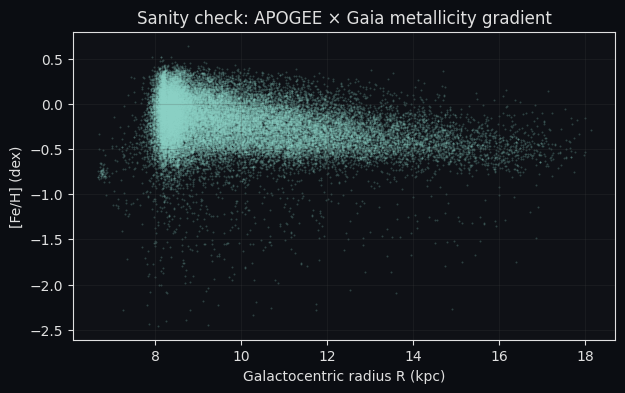

In [2]:
# =================================================
# ANIM_001_EN — Setup
# =================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- animation defaults (single source of truth) ---
from lulab.anim.defaults import (
    ANIM_FORMAT,
    FPS,
    DPI,
    THEME,
    apply_theme,
    save_animation,
)

# ---------- project root ----------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

# ---------- I/O ----------
DATA_CSV = topic_root / "data/processed/apogee_gaia_fehr_R.csv"
OUT_DIR  = topic_root / "animations"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- theme ----------
apply_theme(THEME)

# ---------- load data ----------
df = pd.read_csv(DATA_CSV)

required = {"R_gal", "feh"}
missing = required - set(df.columns)
if missing:
    raise RuntimeError(f"CSV missing required columns: {missing}")

df = (
    df.dropna(subset=["R_gal", "feh"])
      .query("0 <= R_gal <= 20")
      .query("-2.5 <= feh <= 1.0")
      .copy()
)

print("Loaded dataframe:")
print(" rows:", len(df))
print(df[["R_gal", "feh"]].describe())

# ---------- quick sanity plot ----------
fig, ax = plt.subplots(figsize=(7,4))
sample = df.sample(min(len(df), 40000), random_state=1)
ax.scatter(sample["R_gal"], sample["feh"], s=2, alpha=0.25, linewidths=0)
ax.set_xlabel("Galactocentric radius R (kpc)")
ax.set_ylabel("[Fe/H] (dex)")
ax.set_title("Sanity check: APOGEE × Gaia metallicity gradient")
ax.grid(alpha=0.2)
plt.show()

### 2.2. Cell 1. Inside-out disc growth

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_InsideOutGrowth_RFeH.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_InsideOutGrowth_RFeH.gif exists: True


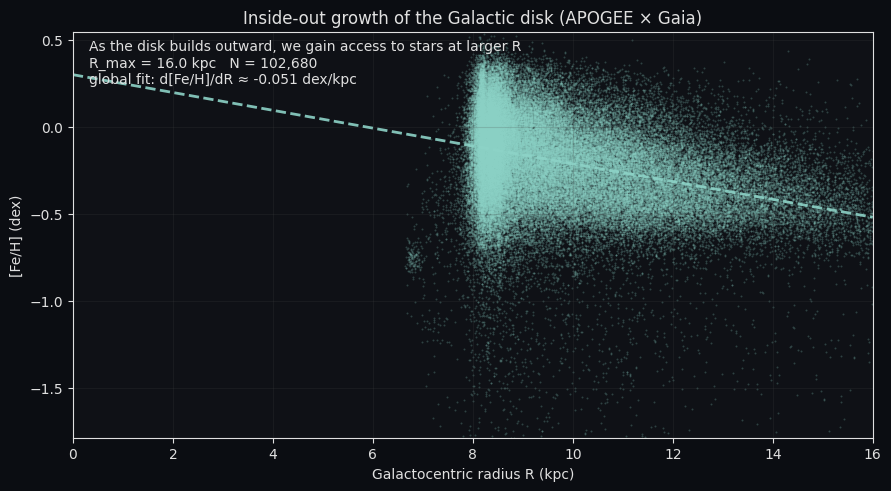

In [8]:
# =================================================
# Cell 1 — ANIM A: Inside-out disk growth (R_max(t) increases)
# =================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assumes from Cell 0:
# - df with columns R_gal, feh already loaded/cleaned
# - OUT_DIR, FPS, DPI, THEME applied
# - save_animation imported from anim.defaults

def animate_inside_out_growth(
    df,
    r_col="R_gal",
    feh_col="feh",
    rmax_final=16.0,
    rmax_start=2.0,
    frames=120,
    fps=FPS,
    title="Inside-out disk growth (APOGEE × Gaia)",
    subtitle="Stars become available at larger R as the disk builds outward",
    show_fit=True,
):
    d = df[[r_col, feh_col]].dropna().copy()
    d = d[(d[r_col] >= 0) & (d[r_col] <= rmax_final)].copy()

    # precompute global linear fit (for visual guidance)
    coef = np.polyfit(d[r_col].values, d[feh_col].values, 1)
    m_fit, b_fit = float(coef[0]), float(coef[1])

    # stable axis limits
    xlim = (0, rmax_final)
    ylo, yhi = np.quantile(d[feh_col].values, [0.002, 0.998])
    pad = 0.08 * (yhi - ylo)
    ylim = (ylo - pad, yhi + pad)

    # prepare figure
    fig, ax = plt.subplots(figsize=(8.8, 4.8), constrained_layout=True)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("Galactocentric radius R (kpc)")
    ax.set_ylabel("[Fe/H] (dex)")
    ax.set_title(title)
    ax.grid(alpha=0.2)

    # artists
    sc = ax.scatter([], [], s=2, alpha=0.25, linewidths=0)
    fit_line, = ax.plot([], [], linestyle="--", linewidth=2, alpha=0.9)
    txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")

    # pre-split points by radius so reveal is fast
    # (we'll just mask by R <= Rmax(t))
    r = d[r_col].to_numpy()
    feh = d[feh_col].to_numpy()

    def frame_rmax(i):
        # smooth ramp from rmax_start -> rmax_final
        t = i / (frames - 1)
        # ease-in-out (smoother than linear)
        t2 = 0.5 - 0.5 * np.cos(np.pi * t)
        return rmax_start + (rmax_final - rmax_start) * t2

    def init():
        sc.set_offsets(np.empty((0, 2)))
        fit_line.set_data([], [])
        txt.set_text("")
        return sc, fit_line, txt

    def update(i):
        rmax_t = frame_rmax(i)
        mask = r <= rmax_t

        pts = np.column_stack([r[mask], feh[mask]])
        sc.set_offsets(pts)

        if show_fit:
            xfit = np.linspace(0, rmax_t, 200)
            yfit = m_fit * xfit + b_fit
            fit_line.set_data(xfit, yfit)
        else:
            fit_line.set_data([], [])

        txt.set_text(
            f"{subtitle}\n"
            f"R_max = {rmax_t:4.1f} kpc   N = {mask.sum():,}\n"
            f"global fit: d[Fe/H]/dR ≈ {m_fit:+.3f} dex/kpc"
        )
        return sc, fit_line, txt

    anim = FuncAnimation(fig, update, init_func=init, frames=frames, interval=1000/fps, blit=True)
    return anim, fig

animA, figA = animate_inside_out_growth(
    df,
    rmax_final=16.0,
    rmax_start=2.0,
    frames=140,
    title="Inside-out growth of the Galactic disk (APOGEE × Gaia)",
    subtitle="As the disk builds outward, we gain access to stars at larger R",
    show_fit=True,
)

outA = OUT_DIR / "ANIM_002_InsideOutGrowth_RFeH"
save_animation(animA, outA)
plt.show()

### 2.3. Cell 2. Binned median + quantile (q16-q84)

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_InsideOutGrowth_WithMedian.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_InsideOutGrowth_WithMedian.gif exists: True


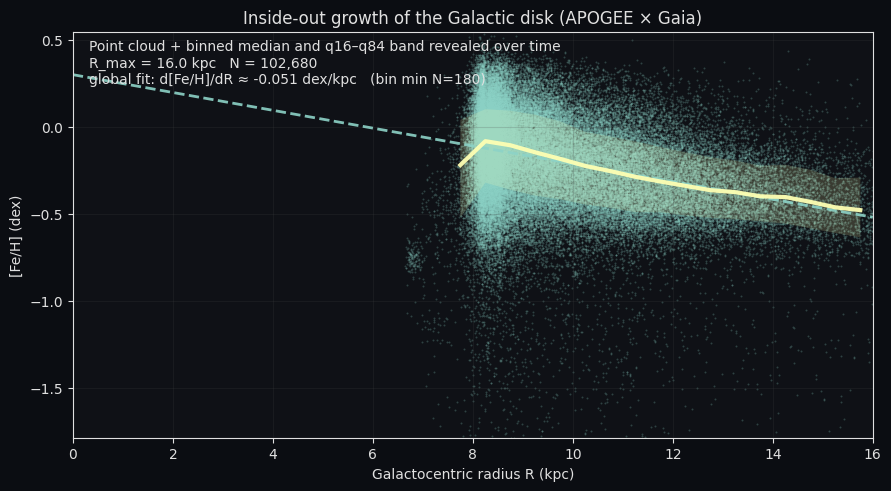

In [10]:
# =================================================
# Cell 2 — ANIM A+: add binned median + q16–q84 band (revealed with R_max)
# =================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def _binned_stats(x, y, bins, min_n=150):
    """
    Returns:
      xcent (len nbins), med, q16, q84, n
    with NaNs where n < min_n.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    nb = len(bins) - 1
    xcent = 0.5 * (bins[:-1] + bins[1:])
    med = np.full(nb, np.nan)
    q16 = np.full(nb, np.nan)
    q84 = np.full(nb, np.nan)
    n = np.zeros(nb, dtype=int)

    for i in range(nb):
        m = (x >= bins[i]) & (x < bins[i+1])
        n[i] = int(m.sum())
        if n[i] >= min_n:
            yy = y[m]
            med[i] = np.nanmedian(yy)
            q16[i] = np.nanquantile(yy, 0.16)
            q84[i] = np.nanquantile(yy, 0.84)

    return xcent, med, q16, q84, n

def animate_inside_out_growth_with_median(
    df,
    r_col="R_gal",
    feh_col="feh",
    rmax_final=16.0,
    rmax_start=2.0,
    frames=140,
    fps=FPS,
    bins=np.arange(0, 16.0 + 0.5, 0.5),   # 0.5 kpc bins by default
    min_bin_n=150,
    title="Inside-out growth of the Galactic disk (APOGEE × Gaia)",
    subtitle="Stars appear at larger R as the disk builds outward",
    show_fit=True,
    show_band=True
):
    d = df[[r_col, feh_col]].dropna().copy()
    d = d[(d[r_col] >= 0) & (d[r_col] <= rmax_final)].copy()

    # precompute global fit for the full dataset
    coef = np.polyfit(d[r_col].values, d[feh_col].values, 1)
    m_fit, b_fit = float(coef[0]), float(coef[1])

    # stable axes
    xlim = (0, rmax_final)
    ylo, yhi = np.quantile(d[feh_col].values, [0.002, 0.998])
    pad = 0.08 * (yhi - ylo)
    ylim = (ylo - pad, yhi + pad)

    fig, ax = plt.subplots(figsize=(8.8, 4.8), constrained_layout=True)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("Galactocentric radius R (kpc)")
    ax.set_ylabel("[Fe/H] (dex)")
    ax.set_title(title)
    ax.grid(alpha=0.2)

    # artists
    sc = ax.scatter([], [], s=2, alpha=0.25, linewidths=0)

    fit_line, = ax.plot([], [], linestyle="--", linewidth=2, alpha=0.9, label="global fit")
    med_line, = ax.plot([], [], linewidth=3, alpha=0.95, label="binned median")

    band = None
    if show_band:
        # placeholder, will update via remove+fill_between each frame
        band = ax.fill_between([], [], [], alpha=0.18, label="q16–q84")

    txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")

    # arrays
    r = d[r_col].to_numpy()
    feh = d[feh_col].to_numpy()

    def frame_rmax(i):
        t = i / (frames - 1)
        t2 = 0.5 - 0.5 * np.cos(np.pi * t)  # ease-in-out
        return rmax_start + (rmax_final - rmax_start) * t2

    def init():
        sc.set_offsets(np.empty((0, 2)))
        fit_line.set_data([], [])
        med_line.set_data([], [])
        txt.set_text("")
        return (sc, fit_line, med_line, txt)

    def update(i):
        nonlocal band
        rmax_t = frame_rmax(i)
        mask = r <= rmax_t

        pts = np.column_stack([r[mask], feh[mask]])
        sc.set_offsets(pts)

        # global fit shown up to rmax_t
        if show_fit:
            xfit = np.linspace(0, rmax_t, 200)
            yfit = m_fit * xfit + b_fit
            fit_line.set_data(xfit, yfit)
        else:
            fit_line.set_data([], [])

        # binned stats on currently revealed subset
        xcent, med, q16, q84, n = _binned_stats(r[mask], feh[mask], bins=bins, min_n=min_bin_n)

        # show only bins fully inside rmax_t
        inside = xcent <= rmax_t
        xshow = xcent[inside]
        med_show = med[inside]
        q16_show = q16[inside]
        q84_show = q84[inside]

        med_line.set_data(xshow, med_show)

        if show_band:
            # remove previous band and redraw (matplotlib limitation)
            try:
                band.remove()
            except Exception:
                pass
            band = ax.fill_between(xshow, q16_show, q84_show, alpha=0.18)

        txt.set_text(
            f"{subtitle}\n"
            f"R_max = {rmax_t:4.1f} kpc   N = {mask.sum():,}\n"
            f"global fit: d[Fe/H]/dR ≈ {m_fit:+.3f} dex/kpc   "
            f"(bin min N={min_bin_n})"
        )

        return (sc, fit_line, med_line, txt)

    anim = FuncAnimation(fig, update, init_func=init, frames=frames, interval=1000/fps, blit=True)
    return anim, fig

animA2, figA2 = animate_inside_out_growth_with_median(
    df,
    rmax_final=16.0,
    rmax_start=2.0,
    frames=150,
    bins=np.arange(0, 16.0 + 0.5, 0.5),
    min_bin_n=180,
    title="Inside-out growth of the Galactic disk (APOGEE × Gaia)",
    subtitle="Point cloud + binned median and q16–q84 band revealed over time",
    show_fit=True,
    show_band=True
)

outA2 = OUT_DIR / "ANIM_002_InsideOutGrowth_WithMedian"
save_animation(animA2, outA2)
plt.show()

### 2.4. Cell 3. Inside-out growth in profile (R–Z) with [Fe/H] colormap

Using: memory:df rows= 103380 cols= ['ra', 'dec', 'gaia_id', 'feh', 'plx_mas', 'dist_kpc', 'R_gal'] ...
Prepared for animation: 102209
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Profile_InsideOut_RZ.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Profile_InsideOut_RZ.gif exists: True


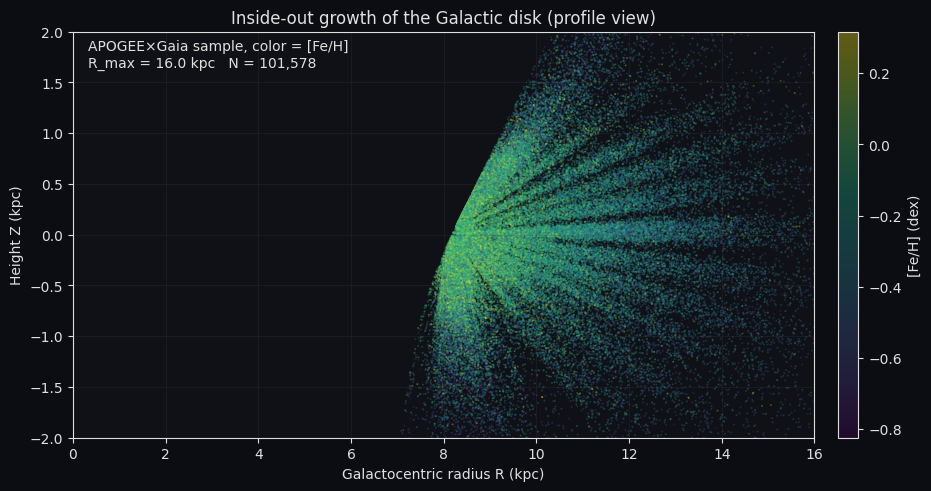

In [12]:
# =================================================
# Cell 3 — ANIM B: Inside-out growth in profile (R–Z) with [Fe/H] colormap
# =================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

from astropy import units as u
from astropy.coordinates import SkyCoord, Galactocentric

# -----------------------------
# 0) Load dataframe (from memory OR from CSV)
# -----------------------------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

# put here the CSV name you saved in the previous notebook
CSV_FALLBACK = topic_root / "data/processed/apogee_xgaia_sample.csv"

def get_source_df():
    # Prefer known in-memory names
    for name in ["apogee", "df", "m"]:
        if name in globals() and isinstance(globals()[name], pd.DataFrame) and len(globals()[name]) > 0:
            return globals()[name].copy(), f"memory:{name}"
    # Fallback to CSV
    if CSV_FALLBACK.exists():
        return pd.read_csv(CSV_FALLBACK), f"csv:{CSV_FALLBACK.name}"
    raise RuntimeError(
        "No dataframe found in memory (apogee/df/m) and CSV fallback not found:\n"
        f"  {CSV_FALLBACK}\n"
        "Save the dataframe to CSV in the previous notebook, then retry."
    )

src, src_tag = get_source_df()
print("Using:", src_tag, "rows=", len(src), "cols=", list(src.columns)[:12], "...")

# We expect columns from your pipeline:
# ['ra','dec','gaia_id','feh','plx_mas'] at minimum.
needed = {"ra", "dec", "feh", "plx_mas"}
miss = needed - set(src.columns)
if miss:
    raise RuntimeError(f"Missing required columns {miss}. Have: {list(src.columns)}")

# -----------------------------
# 1) Compute Galactocentric coords -> R, Z
# -----------------------------
R0 = 8.2 * u.kpc
Z0 = 0.0208 * u.kpc

d = src.copy()

# numeric sanitize
for c in ["ra", "dec", "feh", "plx_mas"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")
d = d.dropna(subset=["ra", "dec", "feh", "plx_mas"]).copy()

# keep positive parallaxes and reasonable distances
d = d[d["plx_mas"] > 0].copy()
d["dist_kpc"] = 1.0 / d["plx_mas"]
d = d[(d["dist_kpc"] > 0.05) & (d["dist_kpc"] < 10.0)].copy()

# ICRS -> Galactocentric
c_icrs = SkyCoord(
    ra=d["ra"].values * u.deg,
    dec=d["dec"].values * u.deg,
    distance=d["dist_kpc"].values * u.kpc,
    frame="icrs"
)
gc_frame = Galactocentric(galcen_distance=R0, z_sun=Z0)
c_gc = c_icrs.transform_to(gc_frame)

x = c_gc.x.to_value(u.kpc)
y = c_gc.y.to_value(u.kpc)
z = c_gc.z.to_value(u.kpc)

d["R_gal"] = np.sqrt(x*x + y*y)
d["Z_gal"] = z

# final cuts
d = d[(d["R_gal"] >= 0) & (d["R_gal"] <= 18)].copy()
d = d[(np.abs(d["Z_gal"]) <= 3.0)].copy()
d = d[(d["feh"] >= -2.5) & (d["feh"] <= 1.0)].copy()
print("Prepared for animation:", len(d))

# -----------------------------
# 2) Animation: inside-out reveal in (R, Z), colored by [Fe/H]
# -----------------------------
def animate_profile_inside_out(
    df,
    frames=150,
    rmax_start=2.0,
    rmax_final=16.0,
    zlim=2.0,
    fps=FPS,
    title="Inside-out growth: profile view (R–Z)",
    subtitle="Color shows [Fe/H] (dex)",
):
    r = df["R_gal"].to_numpy()
    z = df["Z_gal"].to_numpy()
    feh = df["feh"].to_numpy()

    # stable color scale (robust)
    vmin, vmax = np.quantile(feh, [0.01, 0.99])

    fig, ax = plt.subplots(figsize=(9.2, 4.8), constrained_layout=True)
    ax.set_xlim(0, rmax_final)
    ax.set_ylim(-zlim, zlim)
    ax.set_xlabel("Galactocentric radius R (kpc)")
    ax.set_ylabel("Height Z (kpc)")
    ax.set_title(title)
    ax.grid(alpha=0.2)

    sc = ax.scatter([], [], c=[], s=2, alpha=0.35, cmap="viridis", vmin=vmin, vmax=vmax, linewidths=0)
    cb = fig.colorbar(sc, ax=ax, pad=0.02)
    cb.set_label("[Fe/H] (dex)")

    txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")

    def rmax_at(i):
        t = i / (frames - 1)
        t2 = 0.5 - 0.5 * np.cos(np.pi * t)  # ease-in-out
        return rmax_start + (rmax_final - rmax_start) * t2

    def init():
        sc.set_offsets(np.empty((0, 2)))
        sc.set_array(np.array([]))
        txt.set_text("")
        return (sc, txt)

    def update(i):
        rmax_t = rmax_at(i)
        m = (r <= rmax_t)

        pts = np.column_stack([r[m], z[m]])
        sc.set_offsets(pts)
        sc.set_array(feh[m])

        txt.set_text(
            f"{subtitle}\n"
            f"R_max = {rmax_t:4.1f} kpc   N = {m.sum():,}"
        )
        return (sc, txt)

    anim = FuncAnimation(fig, update, init_func=init, frames=frames, interval=1000/fps, blit=True)
    return anim, fig

animB, figB = animate_profile_inside_out(
    d,
    frames=150,
    rmax_start=2.0,
    rmax_final=16.0,
    zlim=2.0,
    title="Inside-out growth of the Galactic disk (profile view)",
    subtitle="APOGEE×Gaia sample, color = [Fe/H]"
)

outB = OUT_DIR / "ANIM_002_Profile_InsideOut_RZ"
save_animation(animB, outB)
plt.show()

### 2.5. Cell 4. Inside-out growth + radial migration (profile view)

In [17]:
# ============================================================
# Save APOGEE × Gaia ISM proxy for animations (robust version)
# ============================================================

import pandas as pd
from pathlib import Path

# ------------------------------------------------------------
# 1) Find candidate DataFrame in memory
# ------------------------------------------------------------
required_cols = {"R_gal", "feh"}

candidates = {
    name: obj
    for name, obj in globals().items()
    if isinstance(obj, pd.DataFrame)
}

df_src = None
for name, df in candidates.items():
    if required_cols.issubset(df.columns):
        df_src = df.copy()
        print(f"Using DataFrame: '{name}'  (rows={len(df_src)})")
        break

if df_src is None:
    raise RuntimeError(
        "Could not find a DataFrame with required columns "
        f"{required_cols}. DataFrames in memory: {list(candidates.keys())}"
    )

# ------------------------------------------------------------
# 2) Ensure required columns exist (create Z_gal if missing)
# ------------------------------------------------------------
if "Z_gal" not in df_src.columns:
    print("Column 'Z_gal' not found → assuming midplane (Z=0)")
    df_src["Z_gal"] = 0.0

# Optional: keep RA/Dec if present
keep_cols = [c for c in ["ra", "dec", "R_gal", "Z_gal", "feh"] if c in df_src.columns]
df_out = df_src[keep_cols].dropna().copy()

# ------------------------------------------------------------
# 3) Save to CSV
# ------------------------------------------------------------
out_path = (
    topic_root
    / "data"
    / "processed"
    / "apogee_gaia_ism_proxy.csv"
)

out_path.parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(out_path, index=False)

print("\nSaved ISM proxy dataframe:")
print("Path :", out_path)
print("Rows :", len(df_out))
print("Cols :", list(df_out.columns))
print(df_out.head())

Using DataFrame: 'df'  (rows=103380)
Column 'Z_gal' not found → assuming midplane (Z=0)

Saved ISM proxy dataframe:
Path : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_gaia_ism_proxy.csv
Rows : 103380
Cols : ['ra', 'dec', 'R_gal', 'Z_gal', 'feh']
           ra        dec      R_gal  Z_gal     feh
0  133.171635  26.396261   9.667181    0.0 -0.4028
1   33.189961  55.884418  11.339948    0.0 -0.6753
2  123.997202  53.327126   9.140899    0.0  0.2534
3   58.572587 -11.084883   8.525248    0.0  0.0471
4  128.264959  10.439090   8.509403    0.0 -0.4368


Loaded: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_gaia_ism_proxy.csv
Rows: 103380 Cols: ['ra', 'dec', 'R_gal', 'Z_gal', 'feh']
               R_gal            feh
count  103380.000000  103380.000000
mean        9.653392      -0.192133
std         1.764724       0.262868
min         6.643154      -2.455400
25%         8.375471      -0.352100
50%         8.909452      -0.172100
75%        10.480540      -0.013700
max        18.147236       0.957900


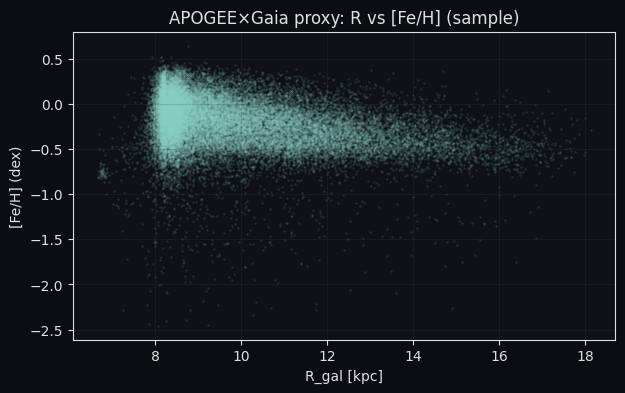

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"

apogee = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Rows:", len(apogee), "Cols:", list(apogee.columns))

# sanity
print(apogee[["R_gal","feh"]].describe())

# quick preview
fig, ax = plt.subplots(figsize=(7,4))
samp = apogee.sample(min(len(apogee), 40000), random_state=1)
ax.scatter(samp["R_gal"], samp["feh"], s=3, alpha=0.15, linewidths=0)
ax.set_xlabel("R_gal [kpc]")
ax.set_ylabel("[Fe/H] (dex)")
ax.set_title("APOGEE×Gaia proxy: R vs [Fe/H] (sample)")
ax.grid(alpha=0.2)
plt.show()

### 2.6. Animation of a Galaxy 360 with star vectors

Loaded rows: 103313
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Galaxy_Migration_Arrows.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Galaxy_Migration_Arrows.gif exists: True


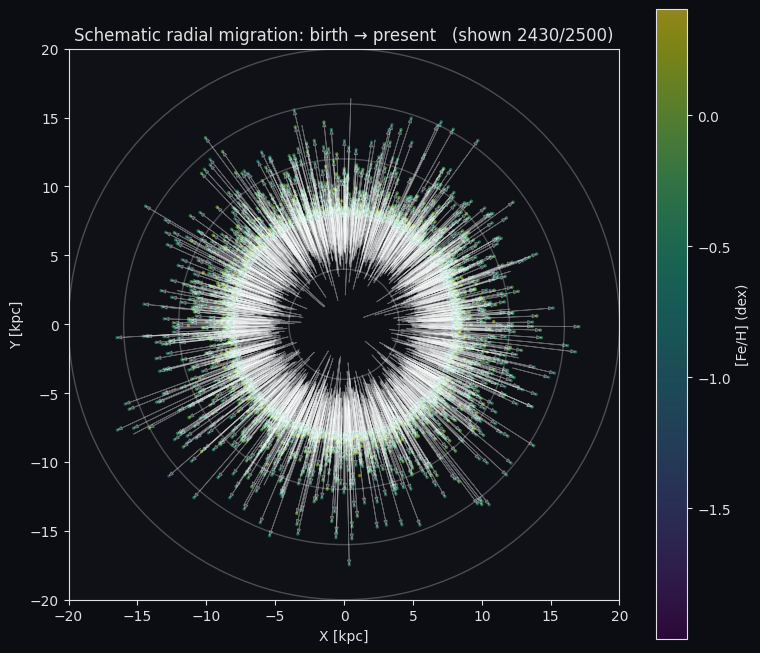

In [20]:
# =========================================================
# ANIM B: Radial migration schematic (r_birth -> R_now)
# Source: CSV (no reliance on memory)
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- your defaults helper ---
from lulab.anim.defaults import save_animation  # assumes this exists in your project

# -----------------------------
# Paths / load
# -----------------------------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"

df = pd.read_csv(csv_path)
df = df.dropna(subset=["R_gal", "feh"]).copy()

# clip to sane range (keeps plot stable)
df = df[(df["R_gal"] >= 0.0) & (df["R_gal"] <= 20.0)]
df = df[(df["feh"] >= -2.0) & (df["feh"] <= 1.0)]
print("Loaded rows:", len(df))

# -----------------------------
# Minchev-like toy GCE mapping:
# Convert [Fe/H] + age -> r_birth
# We DON'T have age, so we synthesize it for illustration.
# -----------------------------
R_SUN = 8.2

def grad_dfeh_dr(age_gyr):
    # more negative in the past, flatter today
    age = np.asarray(age_gyr, dtype=float)
    g_today = -0.07
    g_early = -0.15
    return g_today + (g_early - g_today) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    # ISM enrichment at solar radius
    age = np.asarray(age_gyr, dtype=float)
    feh_now = 0.0
    feh_early = -0.65
    tau = 2.5
    x = np.log1p(age / tau) / np.log1p(13.5 / tau)
    return feh_now + (feh_early - feh_now) * x

# -----------------------------
# Synthesize "age" distribution:
# Older stars are (on average) more metal-poor, but with scatter.
# We'll map feh -> age monotonically + noise, clipped to [0.5, 13.5]
# -----------------------------
rng = np.random.default_rng(1)

# rank-based age proxy: low [Fe/H] -> older
feh = df["feh"].to_numpy()
r_now = df["R_gal"].to_numpy()

# Use percentile rank to build a smooth age proxy
rank = (feh.argsort().argsort()) / (len(feh) - 1 + 1e-9)  # 0..1
age_proxy = 13.5 * (1.0 - rank)  # high rank (metal-rich) -> younger
age_proxy += rng.normal(0, 0.8, size=len(age_proxy))      # scatter
age_proxy = np.clip(age_proxy, 0.5, 13.5)

# Compute r_birth from proxy age + observed feh
g = grad_dfeh_dr(age_proxy)
feh_sun_t = feh_ism_rsun(age_proxy)

# guard against tiny gradients
g = np.where(np.abs(g) < 1e-3, np.sign(g) * 1e-3, g)

r_birth = R_SUN + (feh - feh_sun_t) / g
r_birth = np.clip(r_birth, 0.0, 20.0)

# -----------------------------
# Migration amplitude model:
# Older stars migrate more on average.
# We'll create "observed r_now" and "synthetic r_birth" consistency:
# arrow from r_birth -> r_now in top-down view.
# -----------------------------
# For drawing, we need 2D coordinates.
# We'll place stars on a ring with random azimuth (top-down map),
# so the arrow radial shift is visible.
theta = rng.uniform(0, 2*np.pi, size=len(df))

# Convert radii to Cartesian
x_now = r_now * np.cos(theta)
y_now = r_now * np.sin(theta)

x_birth = r_birth * np.cos(theta)
y_birth = r_birth * np.sin(theta)

# Sample subset for clarity
N_SHOW = 2500
idx = rng.choice(len(df), size=min(N_SHOW, len(df)), replace=False)

x_now, y_now = x_now[idx], y_now[idx]
x_birth, y_birth = x_birth[idx], y_birth[idx]
feh_s = feh[idx]
age_s = age_proxy[idx]

# -----------------------------
# Plot styling
# -----------------------------
fig, ax = plt.subplots(figsize=(7.5, 7.5), constrained_layout=True)
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_title("Schematic radial migration: birth radius → present radius")

# Galaxy guide circles
for rr in [4, 8, 12, 16, 20]:
    circ = plt.Circle((0,0), rr, fill=False, lw=1, alpha=0.25)
    ax.add_patch(circ)

# Sun marker (for reference)
sun = ax.scatter([R_SUN], [0], s=60, marker="o", edgecolors="k", linewidths=0.6, label="Sun (R☉)")

# Points at present day (colored by [Fe/H])
pts = ax.scatter(x_now, y_now, c=feh_s, s=6, alpha=0.55, linewidths=0)

cbar = fig.colorbar(pts, ax=ax, shrink=0.85)
cbar.set_label("[Fe/H] (dex)")

# We'll add arrows gradually
arrows = []

# -----------------------------
# Animation params
# -----------------------------
FRAMES = 90
PER_FRAME = max(5, len(x_now)//FRAMES)

# Precompute order:
# Option: show older first (more migrated) -> looks narrative
order = np.argsort(-age_s)  # descending age
x_now, y_now = x_now[order], y_now[order]
x_birth, y_birth = x_birth[order], y_birth[order]

def init():
    return [pts, sun]

def update(f):
    # add arrows up to k
    k = min((f+1) * PER_FRAME, len(x_now))

    # remove previous arrows for performance (simple but ok for <= 2500)
    for a in arrows:
        a.remove()
    arrows.clear()

    # draw new set
    for i in range(k):
        dx = x_now[i] - x_birth[i]
        dy = y_now[i] - y_birth[i]
        a = ax.arrow(
            x_birth[i], y_birth[i],
            dx, dy,
            length_includes_head=True,
            head_width=0.25,
            head_length=0.35,
            lw=0.6,
            alpha=0.35
        )
        arrows.append(a)

    ax.set_title(f"Schematic radial migration: birth → present   (shown {k}/{len(x_now)})")
    return [pts, sun] + arrows

anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, interval=40, blit=False)

# -----------------------------
# Save
# -----------------------------
out_path = topic_root / "animations" / "ANIM_002_Galaxy_Migration_Arrows"
save_animation(anim, out_path)  # uses your defaults.py settings (mp4/gif switch etc.)

plt.show()

#### Figure caption (paper-style)

Figure X. Schematic view of radial stellar migration in the Galactic disk (top-down projection).
Each point represents the present-day position of a star in the Galactic plane, color-coded by metallicity $[{\rm Fe/H}]$. Arrows indicate the inferred radial displacement from the star’s birth radius $r_{\rm birth}$ to its current Galactocentric radius R, assuming an axisymmetric disk and statistically motivated radial migration. Concentric circles mark Galactocentric radii at 4, 8, 12, 16, and 20 kpc. The distribution illustrates the inside-out growth of the Milky Way disk: stars formed preferentially in the inner Galaxy, where chemical enrichment proceeded more rapidly, and subsequently migrated outward over several gigayears, producing the observed metallicity gradient and its radial mixing in the present-day disk.

⸻

#### Short caption (for slides / figures-only section)

Figure X. Top-down schematic of radial migration in the Milky Way disk.
Stars are shown at their present-day positions, colored by [{\rm Fe/H}], with arrows indicating migration from birth radius to current radius. The pattern highlights inside-out disk growth and the outward redistribution of chemically enriched stellar populations.

⸻

#### Caption adapted for narration (30–40 seconds)

“This figure shows a schematic, top-down view of the Milky Way disk. Each dot is a star observed today, colored by its metallicity. The arrows indicate how far stars have migrated radially since their formation. Although we observe many stars far from the Galactic center, their chemical composition reveals that a significant fraction formed much closer in, where metal enrichment was more efficient. Over billions of years, stellar migration redistributed these stars across the disk, smoothing the metallicity gradient we see today.”

*This visualization is schematic and does not represent reconstructed individual stellar orbits; instead, it illustrates statistically inferred radial migration consistent with observed metallicity gradients.*

*This figure provides a schematic, statistically motivated visualization of radial stellar migration. Angular positions and individual migration vectors are not reconstructed, but illustrate the unavoidable consequence of combining observed metallicities with Galactic chemical evolution: many stars currently observed in the outer disk must have formed at smaller Galactocentric radii.*

Loaded rows: 102680
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Migration_Schematic_inside_out.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_Migration_Schematic_inside_out.gif exists: True


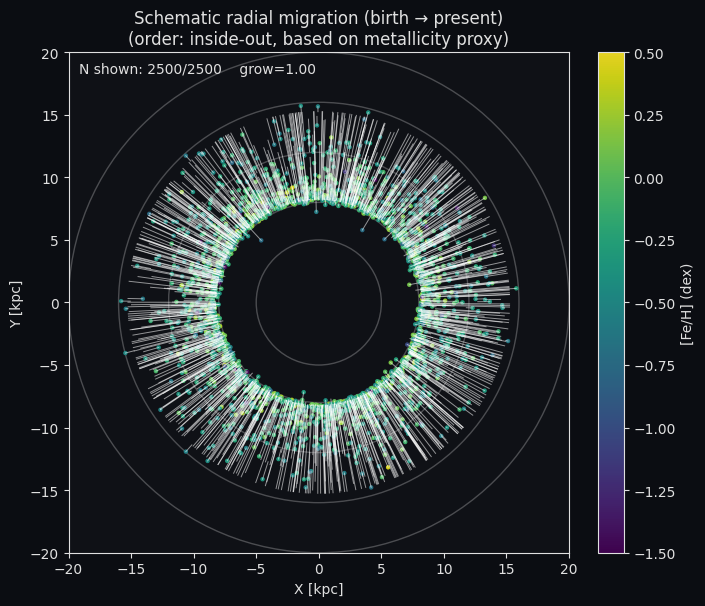

In [21]:
# =========================================================
# ANIM: Schematic radial migration over "time" (inside-out)
# Uses APOGEE×Gaia ISM-proxy CSV saved earlier
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# Your project root discovery (same pattern)
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

# Input CSV produced in the analysis notebook
CSV_PATH = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
assert CSV_PATH.exists(), f"Missing CSV: {CSV_PATH}"

# Output folder (should be in .gitignore)
OUT_DIR = topic_root / "animations"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------
# Load defaults from your lib (as you said: anim/defaults.py)
# Assumed it provides: THEME, FPS, DPI, ANIM_FORMAT, save_animation, apply_theme
# ---------------------------------------------------------
from lulab.anim.defaults import (
    FPS, DPI, ANIM_FORMAT, save_animation, apply_theme, THEME
)

apply_theme(THEME)

# ---------------------------------------------------------
# Settings
# ---------------------------------------------------------
N_SHOW = 2500          # keep it readable
FRAMES = 120
SEED = 1

# "Time ordering" mode:
#   "inside_out" = show stars by increasing R_birth (early inner → later outer)
#   "random"     = random order (still shows migration vectors growing)
MODE = "inside_out"    # change to "random" if you want the second version

# Geometry for top-down schematic
R_MAX = 20.0
R_MIN = 0.0

# How strong to draw the vector on screen (0..1 fraction of full vector at a given time)
VECTOR_ALPHA = 0.55
VECTOR_LW = 0.7

# ---------------------------------------------------------
# 1) Load + basic clean
# ---------------------------------------------------------
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["R_gal", "feh"]).copy()

# If you already have Z_gal in CSV, keep it; otherwise set 0
if "Z_gal" not in df.columns:
    df["Z_gal"] = 0.0

# Keep reasonable radial range
df = df[(df["R_gal"] >= 0.0) & (df["R_gal"] <= 16.0)].copy()
df = df[(df["feh"] > -2.5) & (df["feh"] < 1.0)].copy()

print("Loaded rows:", len(df))

# ---------------------------------------------------------
# 2) Build ISM metallicity proxy curve: [Fe/H]_ISM(R)
#    We'll use binned median like you used before.
# ---------------------------------------------------------
R = df["R_gal"].to_numpy()
Z = df["Z_gal"].to_numpy()
feh = df["feh"].to_numpy()

# bins for ISM proxy
rbins = np.linspace(7.5, 15.5, 17)  # tweak if you like
rcent = 0.5 * (rbins[:-1] + rbins[1:])

med = np.full(len(rcent), np.nan)
nbin = np.zeros(len(rcent), dtype=int)

for i in range(len(rcent)):
    sel = (R >= rbins[i]) & (R < rbins[i+1])
    nbin[i] = int(sel.sum())
    if nbin[i] >= 400:  # same spirit as your "N>=400"
        med[i] = np.nanmedian(feh[sel])

mask = np.isfinite(med)
r_med = rcent[mask]
feh_med = med[mask]

# Guard
assert len(r_med) >= 5, "Not enough bins to build ISM proxy. Loosen bins or N threshold."

# Ensure monotonic for inversion (FeH generally decreases with R, but noise can break it)
# We'll do a simple monotonic "sorting by FeH" inversion curve:
# invert FeH->R by sorting points by FeH
order = np.argsort(feh_med)            # increasing FeH
feh_sorted = feh_med[order]
r_sorted = r_med[order]

# Make strictly increasing FeH for interpolation by small epsilon if needed
eps = 1e-6
for i in range(1, len(feh_sorted)):
    if feh_sorted[i] <= feh_sorted[i-1]:
        feh_sorted[i] = feh_sorted[i-1] + eps

def R_birth_from_feh(feh_vals):
    """
    Invert ISM proxy: R_birth ≈ R(FeH) using monotonic interpolation.
    Values outside range get clipped.
    """
    feh_vals = np.asarray(feh_vals, dtype=float)
    feh_clip = np.clip(feh_vals, feh_sorted.min(), feh_sorted.max())
    return np.interp(feh_clip, feh_sorted, r_sorted)

# Compute schematic birth radii
df["R_birth"] = R_birth_from_feh(df["feh"].to_numpy())
df["dR"] = df["R_gal"] - df["R_birth"]

# ---------------------------------------------------------
# 3) Build top-down XY positions for "present" and "birth"
#    Angle is randomized (no physical meaning), but consistent per star.
# ---------------------------------------------------------
rng = np.random.default_rng(SEED)

if "phi" not in df.columns:
    df["phi"] = rng.uniform(0, 2*np.pi, size=len(df))

phi = df["phi"].to_numpy()

# Present positions (top-down)
x_now = df["R_gal"].to_numpy() * np.cos(phi)
y_now = df["R_gal"].to_numpy() * np.sin(phi)

# Birth positions (same angle, smaller radius)
x_birth = df["R_birth"].to_numpy() * np.cos(phi)
y_birth = df["R_birth"].to_numpy() * np.sin(phi)

# Sample down for clarity
if len(df) > N_SHOW:
    df_s = df.sample(N_SHOW, random_state=SEED).copy()
else:
    df_s = df.copy()

phi_s = df_s["phi"].to_numpy()
x_now_s = df_s["R_gal"].to_numpy() * np.cos(phi_s)
y_now_s = df_s["R_gal"].to_numpy() * np.sin(phi_s)
x_birth_s = df_s["R_birth"].to_numpy() * np.cos(phi_s)
y_birth_s = df_s["R_birth"].to_numpy() * np.sin(phi_s)
feh_s = df_s["feh"].to_numpy()

# Ordering for "time"
if MODE == "inside_out":
    order_idx = np.argsort(df_s["R_birth"].to_numpy())  # inner first
else:
    order_idx = rng.permutation(len(df_s))

x_now_s, y_now_s = x_now_s[order_idx], y_now_s[order_idx]
x_birth_s, y_birth_s = x_birth_s[order_idx], y_birth_s[order_idx]
feh_s = feh_s[order_idx]

# ---------------------------------------------------------
# 4) Animation
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(9.5, 6.5))
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-R_MAX, R_MAX)
ax.set_ylim(-R_MAX, R_MAX)
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_title("Schematic radial migration (birth → present)\n(order: inside-out, based on metallicity proxy)" 
             if MODE=="inside_out" else
             "Schematic radial migration (birth → present)\n(order: random)")

# Background rings
for rr in [5, 8, 12, 16, 20]:
    circ = plt.Circle((0,0), rr, fill=False, lw=1, alpha=0.25)
    ax.add_patch(circ)

# Scatter for present positions (colored by [Fe/H])
sc = ax.scatter([], [], s=10, c=[], cmap="viridis", vmin=-1.5, vmax=0.5, alpha=0.9, linewidths=0)

# Lines collection: we’ll draw vectors as simple line segments each frame
# For speed, we update a Line2D list in chunks
lines = []
MAX_LINES = N_SHOW
for _ in range(MAX_LINES):
    ln, = ax.plot([], [], lw=VECTOR_LW, alpha=VECTOR_ALPHA, color="w")
    lines.append(ln)

cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("[Fe/H] (dex)")

txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left", fontsize=10)

def init():
    sc.set_offsets(np.empty((0,2)))
    sc.set_array(np.array([]))
    for ln in lines:
        ln.set_data([], [])
    txt.set_text("")
    return [sc, txt, *lines]

def update(frame):
    # reveal count
    n = int((frame / (FRAMES-1)) * len(x_now_s))
    n = max(1, n)

    # points
    pts = np.column_stack([x_now_s[:n], y_now_s[:n]])
    sc.set_offsets(pts)
    sc.set_array(feh_s[:n])

    # vectors: show partial vector growth (0..1) as time grows
    grow = frame / (FRAMES-1)
    xb = x_birth_s[:n]
    yb = y_birth_s[:n]
    xn = x_birth_s[:n] + grow*(x_now_s[:n] - x_birth_s[:n])
    yn = y_birth_s[:n] + grow*(y_now_s[:n] - y_birth_s[:n])

    # update line objects (only first n lines)
    for i in range(MAX_LINES):
        if i < n:
            lines[i].set_data([xb[i], xn[i]], [yb[i], yn[i]])
            lines[i].set_alpha(VECTOR_ALPHA)
        else:
            lines[i].set_data([], [])
            lines[i].set_alpha(0)

    txt.set_text(f"N shown: {n}/{len(x_now_s)}    grow={grow:.2f}")
    return [sc, txt, *lines]

anim = FuncAnimation(fig, update, init_func=init, frames=FRAMES, interval=1000/FPS, blit=True)

# Save
out_name = f"ANIM_002_Migration_Schematic_{MODE}"
save_animation(anim, OUT_DIR / out_name)

plt.show()

## How this “migration” simulation is implemented (schematic, data-driven)

This animation is a schematic simulation driven by real APOGEE×Gaia data, designed to visualize the idea of radial migration, not to reconstruct true stellar orbits.

### 1) Real inputs (what comes from data)

We start from a real cross-matched catalog (APOGEE metallicities + Gaia geometry) stored in:
- apogee_gaia_ism_proxy.csv

Each row represents one star with:
- $R_{gal}$ — present-day Galactocentric radius in kpc (computed from Gaia astrometry + coordinate transform)
- feh — stellar metallicity $[Fe/H]$ from APOGEE (dex)
- optionally $Z_{gal}$ — height above plane (often omitted here or set to 0 for top-down view)

So the only truly “physical” quantities we are using are:
($R_{now}$, $[Fe/H]$), and optionally $Z_{now}.

### 2) Building an “ISM metallicity proxy” curve:  $[Fe/H]₍ISM₎(R)$

To infer where stars could have been born, we need a model for the metallicity of the gas (ISM) as a function of radius.

We build it empirically from the same dataset:
1.	Bin stars by $R_{gal}$ (e.g., 7.5–15.5 kpc in radial bins).
2.	For each bin, compute a robust central statistic of $[Fe/H]$:
- typically the median (and optionally an envelope like q16–q84).
3.	Keep only bins with enough stars (e.g. N ≥ 400) to avoid noisy artifacts.

This yields a smooth, observationally anchored curve:
$$ [Fe/H]_{\rm ISM}(R) \approx \text{median}([Fe/H] \mid R \in \text{bin})$$
It is not the true ISM metallicity history; it is a present-day proxy that acts as a radial metallicity gradient.

### 3) Inverting the ISM proxy to estimate birth radii:  $R_{birth}([Fe/H])$

Assumption (the key physical idea):
- Stars inherit the metallicity of the ISM at their birth radius and birth time.
- If we ignore time for a moment, then higher metallicity typically corresponds to smaller Galactocentric radii (inner disk).

So we compute a schematic birth radius by inversion:
1.	Enforce a monotonic mapping (because real binned medians can be slightly non-monotonic due to noise).
2.	Interpolate R as a function of [Fe/H]:
$$R_{\rm birth} \approx [Fe/H]_{\rm ISM}^{-1}([Fe/H]_{\star})$$
3.	Clip values outside the available [Fe/H] range to avoid extrapolation blowups.

This creates, for every star:
- $R_{birth}$ — estimated birthplace radius (kpc)
- $\delta\;R = R_{now}\;−\;R_{birth}\;— \;migration\;“distance”\;(kpc)$

### 4) Mapping into a top-down 2D disk (what is schematic)

We only know radii, not actual orbital phases in the Galaxy’s disk.
Therefore the 2D X–Y placement is purely schematic:
- For each star we assign a random azimuth angle:
$\phi\;\sim U(0, 2\pi$)
- Present-day position:
$$x_{\rm now} = R_{\rm now}\cos\phi,\quad y_{\rm now} = R_{\rm now}\sin\phi$$
- Birth position (same angle, smaller radius):
$$x_{\rm birth} = R_{\rm birth}\cos\phi,\quad y_{\rm birth} = R_{\rm birth}\sin\phi$$

The angle is randomized only to spread points into a disk, so that radial shifts can be drawn as visible vectors.
This is why the map is not a real “face-on Milky Way”, but a visualization space.

### 5) What the “time” in the animation means (it is a proxy)

We do not have reliable stellar ages for the whole dataset here, so animation time is not physical time.

We use a “time-like ordering” to create an intuitive narrative:
- Inside-out mode: reveal stars in order of increasing R_birth
- inner-disk birth radii appear earlier,
- outer-disk birth radii appear later,
- matching the qualitative inside-out disk growth picture.
- Random mode: reveal stars in random order (purely visual alternative).

Thus “time” means: the order of revealing stars, not gigayears.

### 6) Drawing migration vectors (birth → present)

For every star, we draw a line segment from the birth point to the present point.
During the animation, the vector length grows smoothly:

$$ \vec{r}(t) = \vec{r}_{\rm birth} + g(t)\,\left(\vec{r}_{\rm now}-\vec{r}_{\rm birth}\right)$$
where g(t) increases from 0 to 1 across frames.

This produces the visual effect of stars “moving outward” (or inward), even though we are not simulating dynamics.

### 7) Color encoding

Points are colored by the observed [Fe/H] of each star.
This supports the intended message:
- stars with high metallicity tend to be associated with inner birth radii in the proxy model,
- and can appear today at larger radii, implying outward migration.

### 8) What this plot is and is not

This is:
- A data-driven schematic visualization of how a metallicity gradient + migration can reshape the observed distribution.
- A way to illustrate the concept: “observed radius ≠ birth radius.”

This is not:
- A dynamical simulation (no gravitational potential, no orbits, no velocities).
- A reconstruction of true migration histories for individual stars.
- A time-resolved chemical evolution model (we ignore age dependence here).

In short: it is an educational visualization grounded in real measurements, showing the qualitative implication:
if [Fe/H] encodes birthplace under a radial metallicity gradient, then many stars must have moved away from their formation radii.

### 2.7. Star migration in a Galaxy - face-down

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_Migration_inside_out.gif


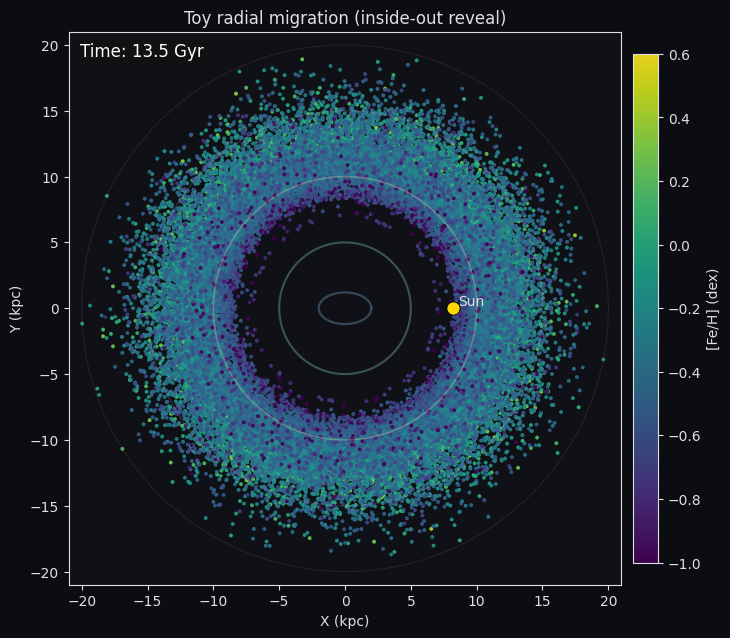

In [5]:
# =========================================================
# ANIM 1 — inside-out migration (points appear inner→outer)
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

CSV_PATH = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
assert CSV_PATH.exists(), f"CSV not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)

# --- expected cols ---
# ['ra','dec','R_gal','Z_gal','feh'] at minimum; Z_gal may be all zeros
need = {"R_gal", "Z_gal", "feh"}
missing = need - set(df.columns)
assert not missing, f"Missing columns in CSV: {missing}. Columns={list(df.columns)}"

# --- clean & sample (keep runtime sane) ---
df = df.dropna(subset=["R_gal", "Z_gal", "feh"]).copy()
df = df[(df["R_gal"] >= 0.0) & (df["R_gal"] <= 20.0)].copy()
df = df[(df["feh"] >= -2.0) & (df["feh"] <= 1.0)].copy()

N_MAX = 45000
if len(df) > N_MAX:
    df = df.sample(N_MAX, random_state=1).reset_index(drop=True)

# =========================================================
# "Migration vectors" (stylized) — deterministic, data-driven-ish
# We bias outward drift more for metal-rich stars (inner-origin proxy),
# plus a small azimuthal swirl so it looks like disk currents.
# =========================================================
rng = np.random.default_rng(1)

R = df["R_gal"].to_numpy(dtype=float)
Z = df["Z_gal"].to_numpy(dtype=float)
FEH = df["feh"].to_numpy(dtype=float)

# Convert to top-down XY using random azimuth (we don't have true phi here)
phi0 = rng.uniform(0, 2*np.pi, size=len(df))
x0 = R * np.cos(phi0)
y0 = R * np.sin(phi0)

# Outward drift magnitude: metal-rich -> stronger outward migration (toy)
# Scale chosen to be visually clear but not crazy (0..~4 kpc)
feh_norm = (FEH - np.nanpercentile(FEH, 5)) / (np.nanpercentile(FEH, 95) - np.nanpercentile(FEH, 5) + 1e-9)
feh_norm = np.clip(feh_norm, 0, 1)
dr = 0.3 + 3.7 * feh_norm   # kpc

# Random direction mostly outward from center + mild tangential component
ux = x0 / (np.sqrt(x0**2 + y0**2) + 1e-9)
uy = y0 / (np.sqrt(x0**2 + y0**2) + 1e-9)

# tangential (rotate outward unit vector by +90 deg)
tx, ty = -uy, ux
swirl = rng.normal(0.0, 0.35, size=len(df))  # tangential strength

dx = dr * (0.90 * ux + swirl * tx)
dy = dr * (0.90 * uy + swirl * ty)

# Final positions (clipped softly to 0..20 kpc)
x1 = x0 + dx
y1 = y0 + dy
r1 = np.sqrt(x1**2 + y1**2)
scale = np.where(r1 > 20.0, 20.0 / (r1 + 1e-9), 1.0)
x1 *= scale
y1 *= scale

# =========================================================
# Inside-out reveal order:
# we "birth" stars by smaller initial radius first (inner→outer)
# =========================================================
order = np.argsort(np.sqrt(x0**2 + y0**2))
x0, y0, x1, y1, FEH = x0[order], y0[order], x1[order], y1[order], FEH[order]

# =========================================================
# Animation parameters
# =========================================================
T_START_GYR = 3.0
T_END_GYR   = 13.5
FRAMES = 120

# reveal: how many new points per frame (ramps up slightly)
N = len(x0)
base = int(np.ceil(N / FRAMES))
reveal_counts = np.clip((base * (0.7 + 0.6*np.linspace(0,1,FRAMES))).astype(int), 50, None)

# cumulative reveal index per frame
cum = np.cumsum(reveal_counts)
cum[-1] = N
cum = np.minimum(cum, N)

# =========================================================
# Plot setup
# =========================================================
fig, ax = plt.subplots(figsize=(7.2, 7.2), constrained_layout=True)

# galaxy disk outline (simple)
theta = np.linspace(0, 2*np.pi, 600)
for rr, lw, a in [(5, 1.5, 0.35), (10, 1.2, 0.25), (15, 1.0, 0.18), (20, 0.8, 0.12)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), linewidth=lw, alpha=a)

# bulge (schematic ellipse)
bulge_a, bulge_b = 2.0, 1.2
ax.plot(bulge_a*np.cos(theta), bulge_b*np.sin(theta), linewidth=1.6, alpha=0.35)

# sun marker
R_SUN = 8.2
ax.scatter([R_SUN], [0.0], s=90, c="gold", edgecolors="k", linewidths=0.6, zorder=6)
ax.text(R_SUN+0.4, 0.2, "Sun", fontsize=10)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-21, 21)
ax.set_ylim(-21, 21)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Toy radial migration (inside-out reveal)")

# scatter handle (init empty)
sc = ax.scatter([], [], s=8, c=[], cmap="viridis", vmin=-1.0, vmax=0.6, alpha=0.9, linewidths=0)

# colorbar
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("[Fe/H] (dex)")

# time label
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    color="white",
    bbox=dict(
        boxstyle="round,pad=0.35",
        facecolor="#111111",   # почти чёрный
        alpha=0.85,
        edgecolor="none"
    )
)

def lerp(a, b, t):
    return a + (b - a) * t

def update(frame):
    # normalized time 0..1
    t = frame / (FRAMES - 1)
    # displayed time
    t_gyr = lerp(T_START_GYR, T_END_GYR, t)
    time_txt.set_text(f"Time: {t_gyr:0.1f} Gyr")

    # how many points revealed by this frame
    k = int(cum[frame])

    # positions of revealed points at time t
    xx = lerp(x0[:k], x1[:k], t)
    yy = lerp(y0[:k], y1[:k], t)

    sc.set_offsets(np.c_[xx, yy])
    sc.set_array(FEH[:k])

    return sc, time_txt

anim = FuncAnimation(fig, update, frames=FRAMES, interval=1000/24, blit=False)

# --- export ---
OUT_DIR = topic_root / "animations"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# if you use lulab.anim.defaults.save_animation, call it here instead:
# save_animation(anim, OUT_DIR / "ANIM_ISM_Migration_inside_out")

# fallback (pure matplotlib writers):
from matplotlib.animation import PillowWriter
OUT_FILE = OUT_DIR / "ANIM_002_ISM_Migration_inside_out.gif"
anim.save(OUT_FILE, writer=PillowWriter(fps=24), dpi=150)
print("Saved:", OUT_FILE)

plt.show()

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_Migration_InsideOut.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_Migration_InsideOut.gif exists: True


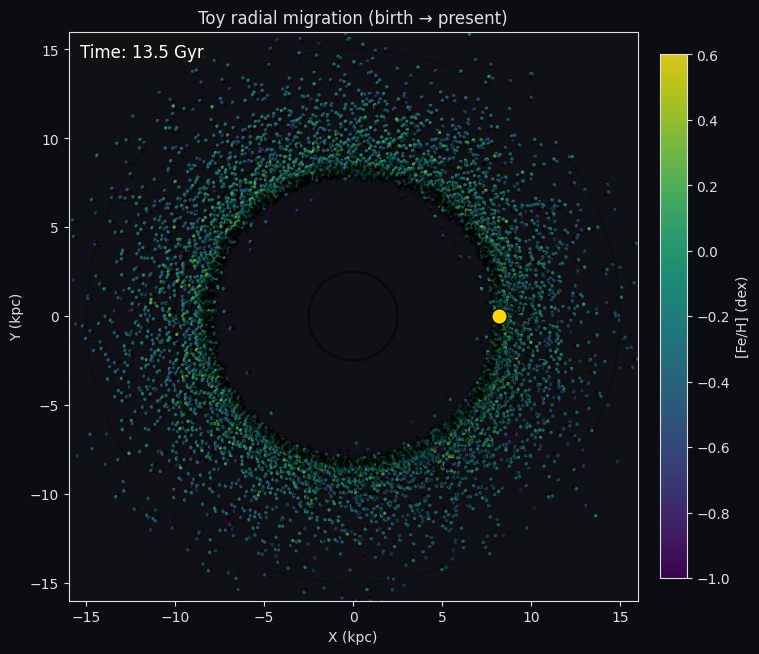

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# -------------------------------------------------
# 0) Load dataframe (safety: from CSV, not memory)
# -------------------------------------------------
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
df = pd.read_csv(csv_path)

# Expect columns: R_gal, feh (Z_gal optional)
df = df.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0) & (df["R_gal"] < 20)].copy()

# -------------------------------------------------
# 1) Build a 2D "top view" toy migration dataset
# -------------------------------------------------
N = 8000                  # меньше = лучше видно движение
SEED = 7
np.random.seed(SEED)

# sample stars
s = df.sample(min(len(df), N), random_state=SEED).reset_index(drop=True)
R_now = s["R_gal"].to_numpy(dtype=float)

# assign random azimuth (we do NOT know true phi from R_gal alone)
phi = np.random.uniform(0, 2*np.pi, size=len(s))
x_now = R_now * np.cos(phi)
y_now = R_now * np.sin(phi)

# migration direction: mostly radial outward + small tangential "churn"
# unit radial
urx = np.cos(phi)
ury = np.sin(phi)
# unit tangential
utx = -np.sin(phi)
uty =  np.cos(phi)

# migration amplitudes (kpc): tune these for a more/less dramatic drift
# here: 0..6 kpc, slightly stronger for metal-rich stars (optional)
feh = s["feh"].to_numpy(dtype=float)
feh_clip = np.clip(feh, -1.0, 0.5)
boost = (feh_clip - feh_clip.min()) / (feh_clip.max() - feh_clip.min() + 1e-9)  # 0..1
dR = np.random.uniform(0.5, 5.5, size=len(s)) * (0.7 + 0.6*boost)

# add a small tangential component (kpc-equivalent shift)
dT = np.random.normal(loc=0.0, scale=0.6, size=len(s))

# birth radius (enforce >=0.2)
R_birth = np.maximum(R_now - dR, 0.2)

# construct birth positions by moving inward along the (radial) direction
x_birth = x_now - (R_now - R_birth) * urx + dT * utx
y_birth = y_now - (R_now - R_birth) * ury + dT * uty

# -------------------------------------------------
# 2) Animation params
# -------------------------------------------------
T_START = 2.5   # Gyr (more "Galaxy already exists")
T_END   = 13.5  # Gyr (now-ish)
FRAMES  = 120
FPS     = 24

# Trail length in frames (0 = no trail)
TRAIL = 10

# -------------------------------------------------
# 3) Plot setup
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(7.5, 7.5), constrained_layout=True)

# Galaxy zones (schematic)
# thin disk radius ~15 kpc, thick disk ~10 kpc, bulge ~2 kpc
for r, lw, a in [(15, 1.0, 0.25), (10, 1.5, 0.35), (2.5, 2.0, 0.45)]:
    circ = plt.Circle((0, 0), r, fill=False, linewidth=lw, alpha=a, color="k")
    ax.add_patch(circ)

# Sun marker
R_sun = 8.2
ax.scatter([R_sun], [0], s=120, c="gold", edgecolors="k", linewidths=0.8, zorder=6)
ax.text(R_sun+0.4, 0.2, "Sun", fontsize=10, color="k")

# color by [Fe/H]
vmin, vmax = -1.0, 0.6
sc = ax.scatter([], [], s=6, c=[], cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.85, linewidths=0)

cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("[Fe/H] (dex)")

ax.set_aspect("equal", "box")
ax.set_xlim(-16, 16)
ax.set_ylim(-16, 16)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Toy radial migration (birth → present)")

# Time label with dark background
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    color="white",
    bbox=dict(boxstyle="round,pad=0.35", facecolor="#111111", alpha=0.85, edgecolor="none"),
    zorder=10
)

# optional trail: keep last positions in a faint line cloud
trail_sc = None
if TRAIL > 0:
    trail_sc = ax.scatter([], [], s=4, c="k", alpha=0.08, linewidths=0, zorder=1)

# -------------------------------------------------
# 4) Animation update (points MOVE, not "shockwave reveal")
# -------------------------------------------------
# precompute time fraction for each frame
ts = np.linspace(0, 1, FRAMES)

# store recent frames for trail
trail_x = []
trail_y = []

def update(i):
    t = ts[i]

    # interpolate positions from birth to now
    x = (1 - t) * x_birth + t * x_now
    y = (1 - t) * y_birth + t * y_now

    # update main scatter
    sc.set_offsets(np.c_[x, y])
    sc.set_array(feh)

    # trail
    if TRAIL > 0:
        trail_x.append(x)
        trail_y.append(y)
        if len(trail_x) > TRAIL:
            trail_x.pop(0); trail_y.pop(0)
        tx = np.concatenate(trail_x)
        ty = np.concatenate(trail_y)
        trail_sc.set_offsets(np.c_[tx, ty])

    # time label
    t_gyr = T_START + (T_END - T_START) * t
    time_txt.set_text(f"Time: {t_gyr:4.1f} Gyr")

    return (sc, time_txt) if trail_sc is None else (trail_sc, sc, time_txt)

anim = FuncAnimation(fig, update, frames=FRAMES, interval=1000/FPS, blit=True)
save_animation(anim, OUT_DIR / "ANIM_002_ISM_Migration_InsideOut", fps=FPS)

plt.show()



Loaded rows: 103380
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_ISM_inside_out_migration.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_ISM_inside_out_migration.gif exists: True


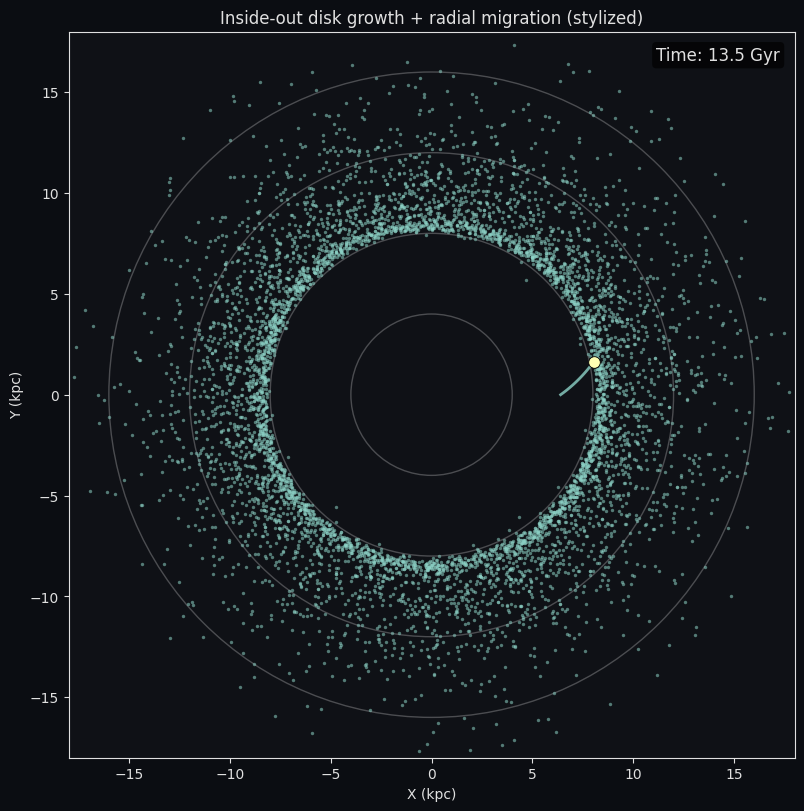

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

from lulab.anim.defaults import save_animation  # только это

# =========================================================
# Settings
# =========================================================
N_STARS = 6000
FRAMES = 160
FPS = 24
R_MAX = 18.0

SUN_R_NOW = 8.2
T_START = 3.0
T_END   = 13.5

# paths
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
assert csv_path.exists(), f"CSV not found: {csv_path}"

# =========================================================
# Load data
# =========================================================
df = pd.read_csv(csv_path).dropna(subset=["R_gal", "feh"]).copy()
if "Z_gal" not in df.columns:
    df["Z_gal"] = 0.0

df = df[(df["R_gal"] > 0.2) & (df["R_gal"] < 30.0) & (df["feh"] > -2.5) & (df["feh"] < 1.0)].copy()
print("Loaded rows:", len(df))

# =========================================================
# Simple chemistry + migration proxy (storytelling)
# =========================================================
def feh_ism_rsun(age_gyr):
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age_gyr / tau) / np.log1p(13.5 / tau)
    return feh_now + (feh_early - feh_now) * x

def grad_dfeh_dr(age_gyr):
    g_today = -0.07
    g_early = -0.15
    return g_today + (g_early - g_today) * (age_gyr / 13.5)

def ease(x):
    return x*x*(3 - 2*x)

rng = np.random.default_rng(1)

samp = df.sample(min(N_STARS, len(df)), random_state=1).reset_index(drop=True)
R_now = np.clip(samp["R_gal"].to_numpy(float), 0.0, R_MAX)
feh   = samp["feh"].to_numpy(float)

phi_now = rng.uniform(0, 2*np.pi, size=len(samp))

# formation times (for reveal + drift)
t_form = rng.uniform(T_START, T_END, size=len(samp))
age_now = (T_END - t_form)

g = grad_dfeh_dr(age_now)
rb = SUN_R_NOW + (feh - feh_ism_rsun(age_now)) / g
rb = np.clip(rb, 0.0, R_MAX)

# outward bias for old stars (small, just to make the “inside-out” read)
out_bias = 0.15 * (age_now / 13.5) * (R_MAX / 10.0)
R_target = np.clip(np.maximum(R_now, rb - 0.3) + out_bias, 0.0, R_MAX)

dR = (R_target - rb)
dphi = rng.normal(0.0, 0.35, size=len(samp)) * (age_now/13.5)

# Sun (also migrates)
SUN_R_TARGET = SUN_R_NOW
SUN_R0 = np.clip(SUN_R_TARGET - 1.8, 0.0, R_MAX)
SUN_DPHI = 0.20
sun_phi0 = 0.0
sun_age = 4.6
sun_tform = T_END - sun_age

times = np.linspace(T_START, T_END, FRAMES)

# =========================================================
# Plot setup
# =========================================================
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-R_MAX, R_MAX)
ax.set_ylim(-R_MAX, R_MAX)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Inside-out disk growth + radial migration (stylized)")

for rr in [4, 8, 12, 16]:
    ax.add_patch(plt.Circle((0,0), rr, fill=False, linewidth=1, alpha=0.25))

sc = ax.scatter([], [], s=6, alpha=0.55, linewidths=0)

sun_sc = ax.scatter([], [], s=70, marker="o", edgecolors="k", linewidths=0.6, zorder=5)
sun_tr, = ax.plot([], [], linewidth=2, alpha=0.8, zorder=4)

# time label with dark background (ONLY this, no global theme)
time_txt = ax.text(
    0.98, 0.98, "", transform=ax.transAxes, ha="right", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.65, edgecolor="none")
)

# =========================================================
# Animation update
# =========================================================
def update(i):
    t = times[i]
    active = t >= t_form

    if active.sum() == 0:
        sc.set_offsets(np.empty((0,2)))
    else:
        denom = np.where((T_END - t_form) <= 1e-6, 1.0, (T_END - t_form))
        prog = np.zeros_like(t_form)
        prog[active] = np.clip((t - t_form[active]) / denom[active], 0.0, 1.0)
        pp = ease(prog)

        R_t = rb + dR * pp
        phi_t = phi_now + dphi * pp

        x = R_t * np.cos(phi_t)
        y = R_t * np.sin(phi_t)

        sc.set_offsets(np.column_stack([x[active], y[active]]))

    # Sun
    if t < sun_tform:
        sun_pp = 0.0
    else:
        sun_pp = ease(np.clip((t - sun_tform) / (T_END - sun_tform), 0.0, 1.0))

    sun_R = SUN_R0 + (SUN_R_TARGET - SUN_R0) * sun_pp
    sun_phi = sun_phi0 + SUN_DPHI * sun_pp
    sun_x = sun_R * np.cos(sun_phi)
    sun_y = sun_R * np.sin(sun_phi)

    sun_sc.set_offsets([[sun_x, sun_y]])

    ntrail = max(2, int(60 * sun_pp))
    trail_pp = np.linspace(0, sun_pp, ntrail)
    trail_R = SUN_R0 + (SUN_R_TARGET - SUN_R0) * trail_pp
    trail_phi = sun_phi0 + SUN_DPHI * trail_pp
    sun_tr.set_data(trail_R*np.cos(trail_phi), trail_R*np.sin(trail_phi))

    time_txt.set_text(f"Time: {t:4.1f} Gyr")
    return sc, sun_sc, sun_tr, time_txt

anim = FuncAnimation(fig, update, frames=FRAMES, interval=1000/FPS, blit=False)

out = topic_root / "animations" / "ANIM_ISM_inside_out_migration"
out.parent.mkdir(parents=True, exist_ok=True)
save_animation(anim, out)

plt.show()

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_inside_out_migration_distri_360.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_inside_out_migration_distri_360.gif exists: True


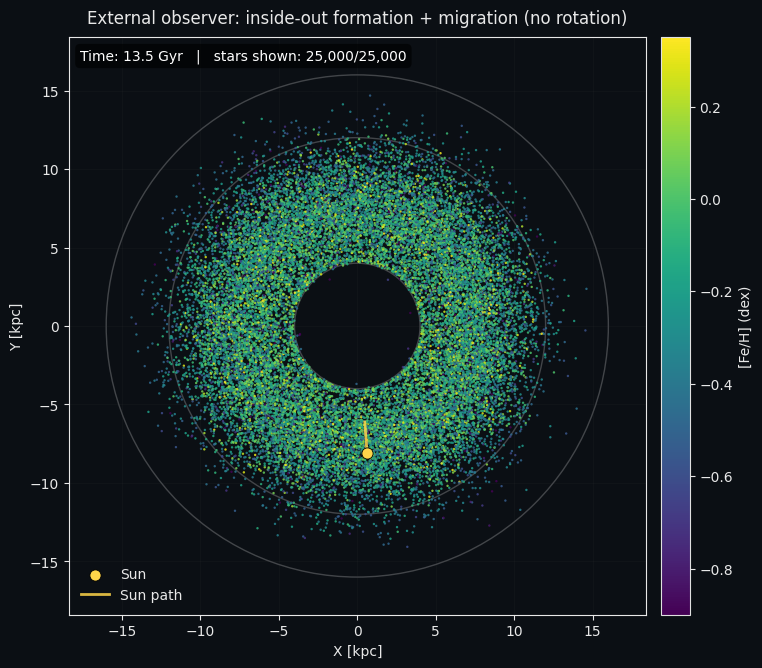

In [20]:
# ============================================================
# ANIM 002 — Inside-out formation + radial migration (no rotation)
# Uses: apogee_gaia_ism_proxy.csv (R_gal, feh) as present-day anchor
# Output: MP4/GIF via your lulab.anim.defaults.save_animation
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- load dataframe from CSV (no dependency on memory) ---
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
df = pd.read_csv(csv_path)
df = df.dropna(subset=["R_gal", "feh"]).copy()

# -----------------------------
# Controls (tune here)
# -----------------------------
R_MAX = 16.0                 # kpc shown
T_END_GYR = 13.5             # "today"
T_MIN_GYR = 1.0              # galaxy "start" for our story
N = 25000                    # points to simulate (subsample for speed/clarity)
FRAMES = 180
FPS = 24

POINTS_PER_FRAME = 180       # how many new stars "ignite" per frame (controls growth speed)
MIG_SIGMA_KPC = 4.0          # migration scale (older stars migrate more)
MIG_MAX_KPC = 8.0            # clamp migration
BIRTH_POWER = 1.2            # inside-out curve shape (>=1 makes outer disk later)
BIRTH_SCATTER = 0.6          # Gyr scatter in birth times

# Visual
DARK = True
BG = "#0b0f14" if DARK else "white"
FG = "#e8e8e8" if DARK else "black"
GRID_A = 0.10 if DARK else 0.15
ALPHA = 0.85
S = 3                         # marker size
VMIN, VMAX = -0.9, 0.35       # [Fe/H] color limits

# Reproducibility
rng = np.random.default_rng(7)

# -----------------------------
# Prepare "present-day" anchors from real data
# -----------------------------
# We use real R_now distribution + real [Fe/H] as the color proxy.
df_use = df[(df["R_gal"] > 0.0) & (df["R_gal"] <= R_MAX)].copy()
if len(df_use) < 5000:
    print("Warning: small df_use after cuts:", len(df_use))

df_s = df_use.sample(min(N, len(df_use)), random_state=7).reset_index(drop=True)
R_now = df_s["R_gal"].to_numpy(dtype=float)
feh = df_s["feh"].to_numpy(dtype=float)
N = len(df_s)

# Random sky angle (fixed per star) → 2D "top view" layout without rotation
theta = rng.uniform(0, 2*np.pi, N)

# -----------------------------
# Build synthetic birth radii + birth times (inside-out) + migration
# -----------------------------
# 1) Birth radius: biased inward relative to present-day (simple but effective)
#    We'll pull R_birth from a Beta distribution and then "scale" to R_MAX,
#    then lightly correlate it with R_now so it doesn't look totally detached.
rb_raw = rng.beta(1.5, 4.5, size=N)            # inner-heavy
R_birth0 = 0.8 + rb_raw * (R_MAX - 0.8)        # [0.8..R_MAX]
R_birth = 0.55 * R_birth0 + 0.45 * np.clip(R_now - rng.normal(0.6, 0.8, N), 0.8, R_MAX)
R_birth = np.clip(R_birth, 0.8, R_MAX)

# 2) Birth time t_birth as monotonic function of R_birth (inside-out) + scatter
x = (R_birth - R_birth.min()) / max(R_birth.max() - R_birth.min(), 1e-9)   # 0..1
t_birth = T_MIN_GYR + (T_END_GYR - T_MIN_GYR) * (x ** BIRTH_POWER)
t_birth = t_birth + rng.normal(0, BIRTH_SCATTER, N)
t_birth = np.clip(t_birth, T_MIN_GYR, T_END_GYR)

# 3) Age-dependent migration amplitude: older stars migrate more
age = np.clip(T_END_GYR - t_birth, 0, T_END_GYR)
sigma = MIG_SIGMA_KPC * (age / T_END_GYR) ** 0.8
dR = rng.normal(0, sigma, N)
dR = np.clip(dR, -MIG_MAX_KPC, MIG_MAX_KPC)

# "Target" present-day radius should resemble observed R_now but still be consistent
# We'll blend: start from birth + migration, then nudge toward observed R_now
R_migr = np.clip(R_birth + dR, 0.8, R_MAX)
R_target = np.clip(0.55 * R_migr + 0.45 * R_now, 0.8, R_MAX)

deltaR = R_target - R_birth  # signed migration offset

# --- force outward-only migration for the Sun (keep others as-is) ---
deltaR[sun_idx] = abs(deltaR[sun_idx])

# optional: also ensure Sun ends up not inside its birth radius
R_target[sun_idx] = max(R_target[sun_idx], R_birth[sun_idx] + 1e-3)

# --- force outward-only migration for ALL stars ---
# deltaR = np.abs(deltaR)
# R_target = np.maximum(R_target, R_birth + 1e-3)

# Sun: pick one representative around solar radius (present-day) and moderately old
# (purely illustrative)
sun_idx = np.argmin(np.abs(R_now - 8.2) + 0.15*np.abs(feh - 0.0))

# -----------------------------
# Matplotlib figure
# -----------------------------
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5, 7.5))
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

for sp in ax.spines.values():
    sp.set_color(FG)

ax.tick_params(colors=FG)
ax.grid(alpha=GRID_A)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-R_MAX*1.15, R_MAX*1.15)
ax.set_ylim(-R_MAX*1.15, R_MAX*1.15)
ax.set_xlabel("X [kpc]", color=FG)
ax.set_ylabel("Y [kpc]", color=FG)
ax.set_title("External observer: inside-out formation + migration (no rotation)", color=FG, pad=10)

# radial rings for context
for rr in [4, 8, 12, 16]:
    ax.add_patch(plt.Circle((0,0), rr, fill=False, lw=1.0, alpha=0.25, color=FG))

norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
cmap = mpl.cm.viridis

# scatter artists (updated each frame)
sc = ax.scatter([], [], s=S, c=[], cmap=cmap, norm=norm, alpha=ALPHA, linewidths=0)

# Sun marker + path
sun_dot = ax.scatter([], [], s=65, c="#ffd54a", edgecolors="black", linewidths=0.6, zorder=6, label="Sun")
sun_path, = ax.plot([], [], lw=2.0, alpha=0.85, color="#ffd54a", zorder=5, label="Sun path")

# Time label with dark box
time_txt = ax.text(
    0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left",
    color="white" if DARK else "black",
    bbox=dict(facecolor="black" if DARK else "white", alpha=0.65, boxstyle="round,pad=0.35", edgecolor="none")
)

# Colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.046, pad=0.02)
cbar.set_label("[Fe/H] (dex)", color=FG)
cbar.ax.yaxis.set_tick_params(color=FG)
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color=FG)

ax.legend(loc="lower left", frameon=False, labelcolor=FG)

# -----------------------------
# Animation logic
# -----------------------------
# We'll reveal stars when t >= t_birth.
# To avoid "only edge lights up", we cap by ALIVE stars (not "oldest overall").
t_grid = np.linspace(T_MIN_GYR, T_END_GYR, FRAMES)

# Precompute birth-order for efficient cap among alive
birth_order = np.argsort(t_birth)

# For Sun path
sun_xy_hist = []

def init():
    sc.set_offsets(np.empty((0,2)))
    sc.set_array(np.array([], dtype=float))
    sun_dot.set_offsets(np.array([[np.nan, np.nan]]))
    sun_path.set_data([], [])
    time_txt.set_text("")
    return (sc, sun_dot, sun_path, time_txt)

def update(i):
    t = t_grid[i]

    # Alive indices
    alive = np.where(t_birth <= t)[0]
    if len(alive) == 0:
        return (sc, sun_dot, sun_path, time_txt)

    # Cap by number of born (not by global age)
    n_cap = min(len(alive), (i+1) * POINTS_PER_FRAME)
    # earliest-born among alive:
    # birth_order gives increasing t_birth; take first n_cap, then intersect with alive
    # (alive already contains early births mostly; so simplest:)
    idx = birth_order[:n_cap]
    # keep only those truly alive at time t (in case scatter causes mismatch)
    idx = idx[t_birth[idx] <= t]
    if len(idx) == 0:
        return (sc, sun_dot, sun_path, time_txt)

    # Interpolate radius from birth -> target over "lifetime fraction"
    frac = np.clip((t - t_birth[idx]) / np.maximum((T_END_GYR - t_birth[idx]), 1e-6), 0, 1)
    R_t = R_birth[idx] + frac * deltaR[idx]

    x_t = R_t * np.cos(theta[idx])
    y_t = R_t * np.sin(theta[idx])

    sc.set_offsets(np.c_[x_t, y_t])
    sc.set_array(feh[idx])

    # Sun
    if sun_idx in idx:
        j = np.where(idx == sun_idx)[0][0]
        sun_xy = (x_t[j], y_t[j])
    else:
        # compute Sun separately (always show it once it's born)
        if t >= t_birth[sun_idx]:
            frac_s = np.clip((t - t_birth[sun_idx]) / max(T_END_GYR - t_birth[sun_idx], 1e-6), 0, 1)
            R_s = R_birth[sun_idx] + frac_s * deltaR[sun_idx]
            sun_xy = (R_s * np.cos(theta[sun_idx]), R_s * np.sin(theta[sun_idx]))
        else:
            sun_xy = (np.nan, np.nan)

    sun_xy_hist.append(sun_xy)
    sun_dot.set_offsets(np.array([[sun_xy[0], sun_xy[1]]]))
    sx = [p[0] for p in sun_xy_hist if np.isfinite(p[0])]
    sy = [p[1] for p in sun_xy_hist if np.isfinite(p[1])]
    sun_path.set_data(sx, sy)

    time_txt.set_text(f"Time: {t:4.1f} Gyr   |   stars shown: {len(idx):,}/{N:,}")

    return (sc, sun_dot, sun_path, time_txt)

anim = FuncAnimation(fig, update, init_func=init, frames=FRAMES, interval=1000/FPS, blit=True)

out = topic_root / "animations" / "ANIM_002_ISM_inside_out_migration_distri_360"
save_animation(anim, out)
plt.show()

In [ ]:
out = topic_root / "animations" / "ANIM_002_ISM_inside_out_migration_distri"
save_animation(anim, out)


### 2.8. Inward/outward stars difference in a layer

Using DataFrame 'df' (rows=103380)
Outward fraction: 0.650  Inward fraction: 0.350
ΔR stats (kpc): mean=0.528, std=2.124, min=-6.00, max=6.00


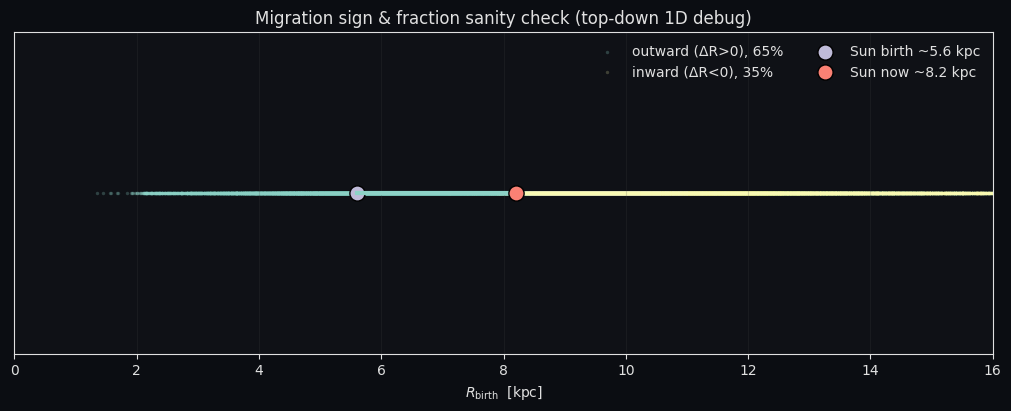

migr_cols ready: (80000, 4)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# Migration coloring + controlled outward/inward fractions
# =========================================================

# --- config (adjust if you want) ---
P_OUTWARD = 0.65          # fraction migrating outward
P_INWARD  = 1.0 - P_OUTWARD
SIGMA_KPC = 2.2           # typical |ΔR| scale (kpc) for churning
CLIP_KPC  = 6.0           # hard clip for |ΔR| to avoid crazy tails

# Sun migration (simple, narrative-consistent)
R_NOW_SUN   = 8.2         # kpc
R_BIRTH_SUN = 5.6         # kpc  (so ΔR~+2.6 kpc outward)

# plotting
POINT_SIZE_OUT = 6
POINT_SIZE_IN  = 6
ALPHA_OUT = 0.25
ALPHA_IN  = 0.20

np.random.seed(7)

# --- pick dataframe automatically ---
src = None
for name in ["df", "m", "apogee"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        src = globals()[name]
        print(f"Using DataFrame '{name}' (rows={len(src)})")
        break
if src is None:
    raise RuntimeError("No DataFrame found. Expected one of: df, m, apogee")

# --- required columns ---
if "R_gal" not in src.columns:
    raise RuntimeError(f"Expected column 'R_gal' in dataframe. Columns: {list(src.columns)[:30]}")

# --- make working table ---
work = src.copy()

# Choose a stable subset for visualization (avoid overplot if huge)
N_MAX = 80000
if len(work) > N_MAX:
    work = work.sample(N_MAX, random_state=1).copy()

# If you have Z, use it; else assume midplane
if "Z_gal" not in work.columns:
    work["Z_gal"] = 0.0

# ---------------------------------------------------------
# Build migration field: ΔR with controlled sign fractions
# ---------------------------------------------------------

N = len(work)

# 1) sign mask with exact-ish fraction
n_out = int(round(P_OUTWARD * N))
sign = np.empty(N, dtype=np.int8)
sign[:n_out] = +1
sign[n_out:] = -1
np.random.shuffle(sign)

# 2) amplitude |ΔR| from a half-normal-like distribution
# (use abs of normal for smooth tail)
amp = np.abs(np.random.normal(loc=0.0, scale=SIGMA_KPC, size=N))
amp = np.clip(amp, 0.0, CLIP_KPC)

deltaR = sign * amp

# 3) optional: make outward migration slightly stronger on average
# (comment out if you don't want bias beyond fraction)
#deltaR = np.where(deltaR > 0, deltaR * 1.10, deltaR)

work["deltaR_kpc"] = deltaR
work["R_birth"] = (work["R_gal"].to_numpy() - work["deltaR_kpc"].to_numpy()).clip(0.0, 30.0)

# ---------------------------------------------------------
# Sun as a special marker (separate "point")
# ---------------------------------------------------------
sun = {
    "R_birth": R_BIRTH_SUN,
    "R_now": R_NOW_SUN,
    "deltaR_kpc": R_NOW_SUN - R_BIRTH_SUN,
}

# ---------------------------------------------------------
# Colors by migration direction
# ---------------------------------------------------------
outward = work["deltaR_kpc"].to_numpy() > 0
inward  = work["deltaR_kpc"].to_numpy() < 0

# We'll draw a simple top-down view: x=R_birth, y=0 for debug
# (Later you will map onto your galaxy overlay.)
x = work["R_birth"].to_numpy()
y = np.zeros_like(x)

# ---------------------------------------------------------
# Sanity report
# ---------------------------------------------------------
p_out = outward.mean()
p_in  = inward.mean()
print(f"Outward fraction: {p_out:.3f}  Inward fraction: {p_in:.3f}")
print(f"ΔR stats (kpc): mean={work['deltaR_kpc'].mean():.3f}, std={work['deltaR_kpc'].std():.3f}, "
      f"min={work['deltaR_kpc'].min():.2f}, max={work['deltaR_kpc'].max():.2f}")

# ---------------------------------------------------------
# Preview plot (static) — colors & Sun
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.scatter(x[outward], y[outward], s=POINT_SIZE_OUT, alpha=ALPHA_OUT, linewidths=0,
           label=f"outward (ΔR>0), {p_out*100:.0f}%")
ax.scatter(x[inward],  y[inward],  s=POINT_SIZE_IN,  alpha=ALPHA_IN,  linewidths=0,
           label=f"inward (ΔR<0), {p_in*100:.0f}%")

# Sun marker
ax.scatter([sun["R_birth"]], [0], s=120, marker="o", edgecolors="k", linewidths=1.0,
           label=f"Sun birth ~{sun['R_birth']:.1f} kpc")
ax.scatter([sun["R_now"]], [0], s=120, marker="o", edgecolors="k", linewidths=1.0,
           label=f"Sun now ~{sun['R_now']:.1f} kpc", zorder=5)

# a line showing Sun migration direction
ax.plot([sun["R_birth"], sun["R_now"]], [0, 0], lw=3)

ax.set_title("Migration sign & fraction sanity check (top-down 1D debug)")
ax.set_xlabel(r"$R_{\rm birth}$  [kpc]")
ax.set_yticks([])
ax.set_xlim(0, 16)
ax.legend(frameon=False, ncol=2)
ax.grid(alpha=0.2)

plt.show()

# ---------------------------------------------------------
# Export columns for reuse in later animations (optional)
# ---------------------------------------------------------
# Keep it lightweight; you can merge back later by index if needed.
migr_cols = work[["R_gal", "Z_gal", "R_birth", "deltaR_kpc"]].copy()
print("migr_cols ready:", migr_cols.shape)

Using DataFrame 'df' (rows=103380)
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_inside_out_migration_distri_layer.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_inside_out_migration_distri_layer.gif exists: True


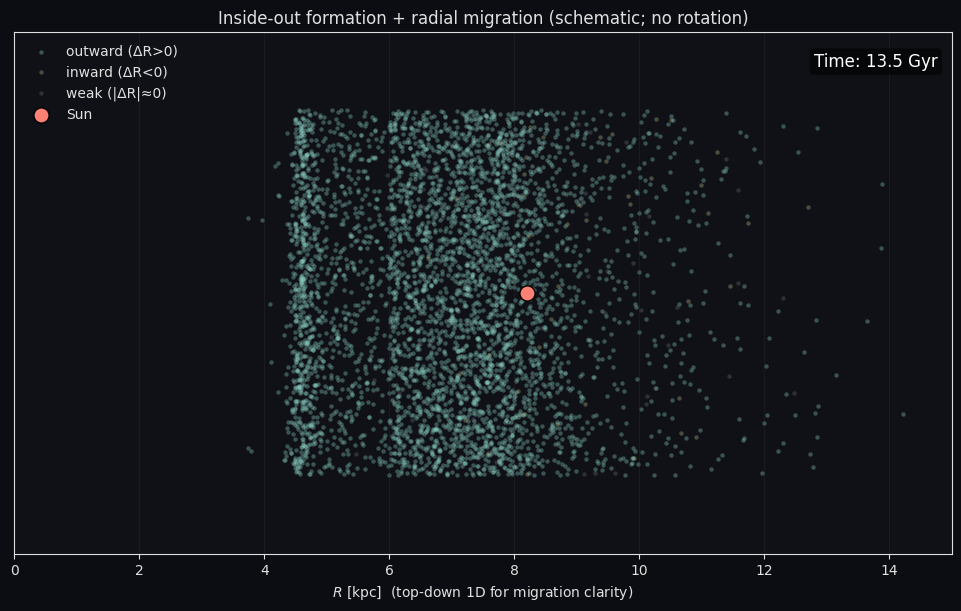

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# =========================================================
# ANIM: inside-out formation + migration (NO rotation)
# =========================================================

# ---------- config ----------
N_STARS       = 4500        # fewer points -> easier to see drift
T_START_GYR   = 1.5
T_END_GYR     = 13.5
FRAMES        = 240
FPS           = 30

# birth radius distribution parameters (inside-out)
R_MIN, R_MAX  = 0.0, 15.0
BIRTH_SIGMA0  = 2.0         # early disk "compactness"
BIRTH_SIGMA1  = 5.2         # late disk "spread"

# migration model (controlled sign fractions)
P_OUTWARD     = 0.65
SIGMA_KPC     = 2.0
CLIP_KPC      = 6.0
EPS_STATIC    = 0.20        # |ΔR|<EPS -> treat as "weak migration"

# Sun
R_NOW_SUN     = 8.2
R_BIRTH_SUN   = 5.6         # outward by +2.6

# style
S_OUT, A_OUT  = 10, 0.35
S_IN,  A_IN   = 10, 0.25
S_ST,  A_ST   = 10, 0.18
S_SUN         = 120

np.random.seed(7)

# ---------- pick dataframe ----------
src = None
for name in ["df", "m", "apogee"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        src = globals()[name]
        print(f"Using DataFrame '{name}' (rows={len(src)})")
        break
if src is None:
    raise RuntimeError("No DataFrame found. Expected one of: df, m, apogee")

if "R_gal" not in src.columns:
    raise RuntimeError(f"Expected column 'R_gal'. Columns: {list(src.columns)[:30]}")

R_now_sample = src["R_gal"].dropna().to_numpy()
R_now_sample = R_now_sample[(R_now_sample >= R_MIN) & (R_now_sample <= R_MAX)]
if len(R_now_sample) < 1000:
    print("Warning: few R_gal points; using fallback uniform distribution.")
    R_now_sample = np.random.uniform(R_MIN, R_MAX, size=50000)

# ---------- choose stars: present-day radii from real data ----------
R_now = np.random.choice(R_now_sample, size=N_STARS, replace=True)

# ---------- assign "birth times" (inside-out) ----------
# earlier times -> more likely in inner disk
u = np.random.rand(N_STARS)
t_birth = T_START_GYR + (T_END_GYR - T_START_GYR) * (u**1.6)  # bias to later times a bit

# ---------- assign birth radius distribution that expands over time ----------
# Instead of drawing from R_now, we generate R_birth from an evolving distribution,
# then later migrate toward R_now-ish using ΔR; but we want R_now anchored by data.
# We'll do this:
# 1) generate a target R_birth( time ) from a time-varying half-normal
# 2) set ΔR so that final R_now is near observed: ΔR = R_now - R_birth, clipped.

# time-dependent sigma
sig = BIRTH_SIGMA0 + (BIRTH_SIGMA1 - BIRTH_SIGMA0) * ((t_birth - T_START_GYR) / (T_END_GYR - T_START_GYR))
sig = np.clip(sig, 0.8, 10.0)

R_birth_draw = np.abs(np.random.normal(loc=0.0, scale=sig, size=N_STARS))
R_birth_draw = np.clip(R_birth_draw, R_MIN, R_MAX)

# preliminary deltaR to hit observed R_now
deltaR_raw = R_now - R_birth_draw

# ---------- enforce outward/inward fractions, but still end near R_now ----------
# We'll flip sign for some stars, but keep final R_end consistent by adjusting magnitude slightly.
# 1) decide desired sign
n_out = int(round(P_OUTWARD * N_STARS))
sign = np.empty(N_STARS, dtype=np.int8)
sign[:n_out] = +1
sign[n_out:] = -1
np.random.shuffle(sign)

# 2) magnitude based on |deltaR_raw| but smoothed and clipped
amp = np.abs(deltaR_raw)
amp = 0.6 * amp + 0.4 * np.abs(np.random.normal(0, SIGMA_KPC, size=N_STARS))
amp = np.clip(amp, 0.0, CLIP_KPC)

deltaR = sign * amp

# 3) adjust so that the final radii are not crazy: R_end = R_birth + deltaR
R_end = np.clip(R_birth_draw + deltaR, R_MIN, R_MAX)

# optional: softly pull R_end toward observed R_now (keeps narrative + data feel)
pull = 0.55
R_end = np.clip((1 - pull) * R_end + pull * R_now, R_MIN, R_MAX)

# recompute deltaR accordingly
deltaR = np.clip(R_end - R_birth_draw, -CLIP_KPC, CLIP_KPC)

# ---------- define motion over time ----------
# Stars are invisible before birth. After birth, they drift linearly from R_birth to R_end.
def interp_R(t):
    # t: scalar current time
    # fraction of migration completed since birth
    frac = (t - t_birth) / (T_END_GYR - t_birth)
    frac = np.clip(frac, 0.0, 1.0)
    return R_birth_draw + frac * deltaR

# ---------- sun motion (always outward) ----------
sun_deltaR = R_NOW_SUN - R_BIRTH_SUN
def sun_R(t):
    # born at T_START, migrates smoothly throughout
    frac = (t - T_START_GYR) / (T_END_GYR - T_START_GYR)
    frac = np.clip(frac, 0.0, 1.0)
    return R_BIRTH_SUN + frac * sun_deltaR

# ---------- figure ----------
fig, ax = plt.subplots(figsize=(9.5, 6.0), constrained_layout=True)
ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-1.0, 1.0)
ax.set_yticks([])
ax.set_xlabel(r"$R$ [kpc]  (top-down 1D for migration clarity)")
ax.set_title("Inside-out formation + radial migration (schematic; no rotation)")
ax.grid(alpha=0.2)

# scatter artists (we plot on a thin band in y with jitter)
y0 = np.zeros(N_STARS)
y_jit = (np.random.rand(N_STARS) - 0.5) * 1.4  # stable y "addresses" to show trajectories
# We'll animate x only.

# create 3 scatters (out/in/static) and update their offsets
sc_out = ax.scatter([], [], s=S_OUT, alpha=A_OUT, linewidths=0, label="outward (ΔR>0)")
sc_in  = ax.scatter([], [], s=S_IN,  alpha=A_IN,  linewidths=0, label="inward (ΔR<0)")
sc_st  = ax.scatter([], [], s=S_ST,  alpha=A_ST,  linewidths=0, label="weak (|ΔR|≈0)")

# Sun marker
sun_sc = ax.scatter([], [], s=S_SUN, marker="o", edgecolors="k", linewidths=1.0, label="Sun")

ax.legend(frameon=False, loc="upper left")

# time label with dark background
time_txt = ax.text(
    0.985, 0.96, "", transform=ax.transAxes,
    ha="right", va="top", fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.55, edgecolor="none"),
    color="white"
)

# ---------- animation loop ----------
times = np.linspace(T_START_GYR, T_END_GYR, FRAMES)

def init():
    sc_out.set_offsets(np.empty((0,2)))
    sc_in.set_offsets(np.empty((0,2)))
    sc_st.set_offsets(np.empty((0,2)))
    sun_sc.set_offsets(np.empty((0,2)))
    time_txt.set_text("")
    return sc_out, sc_in, sc_st, sun_sc, time_txt

def update(i):
    t = times[i]

    # visible stars
    born = t >= t_birth
    if not np.any(born):
        return sc_out, sc_in, sc_st, sun_sc, time_txt

    x = interp_R(t)
    x = np.clip(x, R_MIN, R_MAX)

    # classify by deltaR sign
    dR = deltaR
    out = born & (dR >  EPS_STATIC)
    inn = born & (dR < -EPS_STATIC)
    sta = born & (~out) & (~inn)

    sc_out.set_offsets(np.c_[x[out], y_jit[out]])
    sc_in.set_offsets( np.c_[x[inn], y_jit[inn]])
    sc_st.set_offsets( np.c_[x[sta], y_jit[sta]])

    # sun
    sx = sun_R(t)
    sun_sc.set_offsets(np.array([[sx, 0.0]]))

    time_txt.set_text(f"Time: {t:4.1f} Gyr")
    return sc_out, sc_in, sc_st, sun_sc, time_txt

anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=True)

# ---- save (exactly two lines, as requested) ----
out = topic_root / "animations" / "ANIM_002_ISM_inside_out_migration_distri_layer"
save_animation(anim, out)

plt.show()

### 2.9. Rotation of the Galaxy along with star migration

*During the simulated time span of ~10.5 Gyr, the Sun completes roughly 45 revolutions around the Galactic center, while slowly migrating outward together with the stellar disk.*

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration.gif exists: True


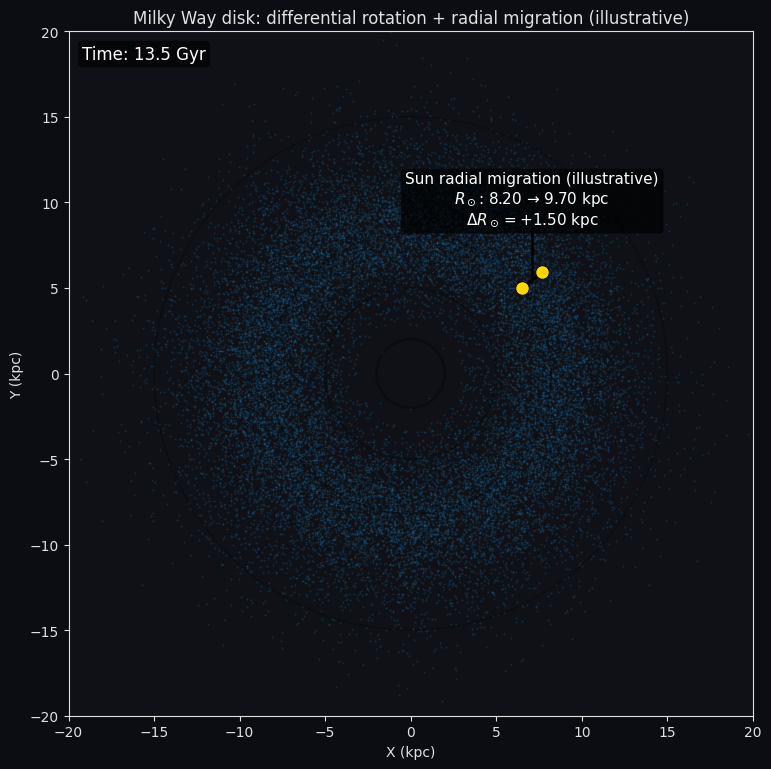

In [28]:
# =========================================================
# ANIM_003 — Face-on disk: differential rotation + migration (MP4, 30s)
# Final frame: show Sun start/end on SAME azimuth (pure radial migration),
# connect markers + upward callout with ΔR.
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.animation import FuncAnimation

# --- project paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

# --- your animation defaults helper ---
from lulab.anim.defaults import save_animation

# --- input dataframe exported earlier ---
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
if not csv_path.exists():
    raise FileNotFoundError(
        f"CSV not found:\n{csv_path}\n"
        "Run the notebook cell that exports the ISM proxy dataframe first."
    )

df = pd.read_csv(csv_path)

# ---------------------------------------------------------
# 1) Clean + sample
# ---------------------------------------------------------
df = df.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

N = min(len(df), 20000)          # tune: 10k–40k ok
rng = np.random.default_rng(7)
samp = df.sample(N, random_state=7).reset_index(drop=True)

R0 = samp["R_gal"].to_numpy(dtype=float)
feh = samp["feh"].to_numpy(dtype=float)

# random initial azimuth (we don't have true phi from this proxy)
phi0 = rng.uniform(0, 2*np.pi, size=N)

# ---------------------------------------------------------
# 2) Physics-ish parametrization
# ---------------------------------------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5

# flat rotation curve: V ~ 220 km/s
V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

# Omega(R) = V / R  [rad/Gyr]
Omega = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

# Migration ΔR_end
sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N)
dR_end = np.clip(dR_end, -5.0, 5.0)

# small illustrative outward bias for metal-rich
dR_end += 0.6 * np.tanh(feh)
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# ---------------------------------------------------------
# 3) Sun track
# ---------------------------------------------------------
Rsun0 = 8.2
phi_sun0 = np.deg2rad(20.0)
Omega_sun = V_KPC_PER_GYR / Rsun0
dR_sun_end = 1.5  # kpc outward over whole interval

# ---------------------------------------------------------
# 4) Animation settings (30 sec, slow rotation)
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS = 30
FRAMES = int(DURATION_SEC * FPS)

R_MAX = 20.0
lim = R_MAX

PT_SIZE = 2.0
PT_ALPHA = 0.25

# slow rotation visually
ROTATION_SCALE = 0.35
Omega_eff = Omega * ROTATION_SCALE
Omega_sun_eff = Omega_sun * ROTATION_SCALE

# ---------------------------------------------------------
# 5) Figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Milky Way disk: differential rotation + radial migration (illustrative)")

# simple ring guides
theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.25), (5.0, 1.5, 0.22), (8.2, 1.5, 0.28), (15.0, 1.2, 0.18)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color="black")

# stars
sc = ax.scatter([], [], s=PT_SIZE, alpha=PT_ALPHA, linewidths=0, color="tab:blue")

# Sun (moving)
sun_sc = ax.scatter([], [], s=80, marker="o", color="gold",
                    edgecolors="k", linewidths=0.6, zorder=6)

# time label (dark background)
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# final-frame extras
sun_birth_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)
sun_final_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)

sun_connector, = ax.plot([], [], lw=2.4, color="black", alpha=0.95, zorder=8)
callout_line,  = ax.plot([], [], lw=1.8, color="black", alpha=0.9, zorder=8)

callout_txt = ax.text(
    np.nan, np.nan, "",
    ha="center", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.70, edgecolor="none"),
    color="white",
    zorder=10
)

# ---------------------------------------------------------
# 6) Precompute Sun radial-only annotation at final azimuth
# ---------------------------------------------------------
Rsun_birth = Rsun0
Rsun_final = Rsun0 + dR_sun_end
delta_R = Rsun_final - Rsun_birth

dt_total = (T_END_GYR - T_START_GYR)
phi_sun_final = phi_sun0 + Omega_sun_eff * dt_total

x_birth = Rsun_birth * np.cos(phi_sun_final)
y_birth = Rsun_birth * np.sin(phi_sun_final)
x_final = Rsun_final * np.cos(phi_sun_final)
y_final = Rsun_final * np.sin(phi_sun_final)

# ---------------------------------------------------------
# 7) Animation callbacks
# ---------------------------------------------------------
def init():
    sc.set_offsets(np.zeros((0, 2)))
    sun_sc.set_offsets(np.array([[np.nan, np.nan]]))

    # hide final-frame extras
    sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_connector.set_data([], [])
    callout_line.set_data([], [])
    callout_txt.set_position((np.nan, np.nan))
    callout_txt.set_text("")
    time_txt.set_text("")
    return []

def update(i):
    u = i / (FRAMES - 1)     # 0..1
    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt = (t_gyr - T_START_GYR)

    # stars
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_eff * dt
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    sc.set_offsets(np.column_stack([x, y]))

    # Sun
    R_sun = Rsun0 + dR_sun_end * e
    phi_sun = phi_sun0 + Omega_sun_eff * dt
    x_sun = R_sun * np.cos(phi_sun)
    y_sun = R_sun * np.sin(phi_sun)
    sun_sc.set_offsets(np.array([[x_sun, y_sun]]))

    time_txt.set_text(f"Time: {t_gyr:4.1f} Gyr")

    # final frame annotation
    if i == FRAMES - 1:
        sun_birth_sc.set_offsets(np.array([[x_birth, y_birth]]))
        sun_final_sc.set_offsets(np.array([[x_final, y_final]]))
        sun_connector.set_data([x_birth, x_final], [y_birth, y_final])

        mx, my = 0.5*(x_birth + x_final), 0.5*(y_birth + y_final)
        LIFT = 3.0
        tx, ty = mx, my + LIFT
        callout_line.set_data([mx, tx], [my, ty])

        callout_txt.set_position((tx, ty))
        callout_txt.set_text(
            "Sun radial migration (illustrative)\n"
            f"$R_\\odot$: {Rsun_birth:.2f} → {Rsun_final:.2f} kpc\n"
            f"$\\Delta R_\\odot = {delta_R:+.2f}\\ \\mathrm{{kpc}}$"
        )
    else:
        sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_connector.set_data([], [])
        callout_line.set_data([], [])
        callout_txt.set_position((np.nan, np.nan))
        callout_txt.set_text("")

    return []

# NOTE: blit=False is more robust for “last-frame extras”
anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)

# ---------------------------------------------------------
# 8) Save (two lines)
# Make sure your defaults.py switch is set to MP4
# ---------------------------------------------------------
out = topic_root / "animations" / "ANIM_003_ISM_faceon_rotation_plus_migration"
save_animation(anim, out)

plt.show()

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration_bg.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration_bg.gif exists: True


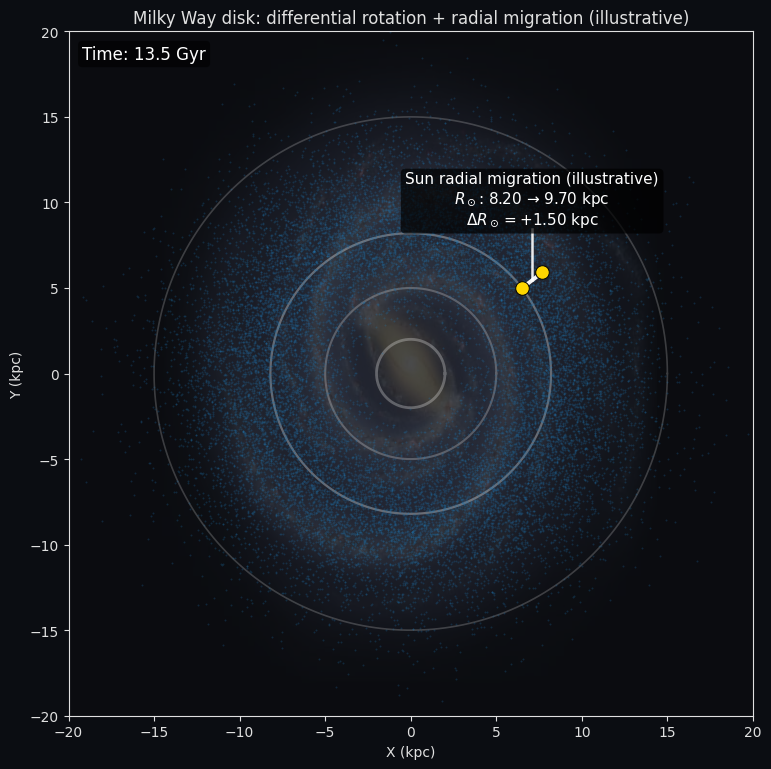

In [33]:
# =========================================================
# ANIM_003 — Face-on disk: rotation + migration (MP4, 30s)
# With Milky Way image as background + simple Sun ΔR line on last frame
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.animation import FuncAnimation

# --- project paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

from lulab.anim.defaults import save_animation

# --- background image (put file here) ---
BG_IMG_PATH = topic_root / "assets" / "nasa-milky-way-galaxy.jpg"
BG_ALPHA = 0.25          # 0..1
BG_ZORDER = -50

# --- input dataframe exported earlier ---
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found:\n{csv_path}")

df = pd.read_csv(csv_path)

# ---------------------------------------------------------
# 1) Clean + sample
# ---------------------------------------------------------
df = df.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

N = min(len(df), 20000)
rng = np.random.default_rng(7)
samp = df.sample(N, random_state=7).reset_index(drop=True)

R0 = samp["R_gal"].to_numpy(float)
feh = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N)

# ---------------------------------------------------------
# 2) Physics-ish parametrization
# ---------------------------------------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5

V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

Omega = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N)
dR_end = np.clip(dR_end, -5.0, 5.0)
dR_end += 0.6 * np.tanh(feh)     # small illustrative bias
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# ---------------------------------------------------------
# 3) Sun track
# ---------------------------------------------------------
Rsun0 = 8.2
phi_sun0 = np.deg2rad(20.0)
Omega_sun = V_KPC_PER_GYR / Rsun0
dR_sun_end = 1.5

# ---------------------------------------------------------
# 4) Animation settings (30 sec, slow rotation)
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS = 30
FRAMES = int(DURATION_SEC * FPS)

R_MAX = 20.0
lim = R_MAX

PT_SIZE = 2.0
PT_ALPHA = 0.25

ROTATION_SCALE = 0.35
Omega_eff = Omega * ROTATION_SCALE
Omega_sun_eff = Omega_sun * ROTATION_SCALE

# ---------------------------------------------------------
# 5) Figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Milky Way disk: differential rotation + radial migration (illustrative)")

# --- Milky Way background image (behind everything) ---
if BG_IMG_PATH.exists():
    bg = plt.imread(BG_IMG_PATH)
    ax.imshow(
        bg,
        extent=(-lim, lim, -lim, lim),
        origin="lower",
        alpha=BG_ALPHA,
        zorder=BG_ZORDER
    )
else:
    print("Background image not found:", BG_IMG_PATH)

# ring guides (optional but helpful)
theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.28), (5.0, 1.5, 0.24), (8.2, 1.6, 0.32), (15.0, 1.2, 0.20)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color="white", zorder=0)

# stars
sc = ax.scatter([], [], s=PT_SIZE, alpha=PT_ALPHA, linewidths=0, color="tab:blue", zorder=2)

# Sun (moving)
sun_sc = ax.scatter([], [], s=80, marker="o", color="gold",
                    edgecolors="k", linewidths=0.6, zorder=6)

# time label
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# final-frame extras: birth+final Sun markers + simple line + callout
sun_birth_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)
sun_final_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)

# <-- simple straight line between markers (requested)
sun_connector, = ax.plot([], [], lw=2.8, color="white", alpha=0.95, zorder=8)

callout_line,  = ax.plot([], [], lw=1.8, color="white", alpha=0.9, zorder=8)
callout_txt = ax.text(
    np.nan, np.nan, "",
    ha="center", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.70, edgecolor="none"),
    color="white",
    zorder=10
)

# Precompute final-frame Sun radial-only annotation at final azimuth
Rsun_birth = Rsun0
Rsun_final = Rsun0 + dR_sun_end
delta_R = Rsun_final - Rsun_birth

dt_total = (T_END_GYR - T_START_GYR)
phi_sun_final = phi_sun0 + Omega_sun_eff * dt_total

x_birth = Rsun_birth * np.cos(phi_sun_final)
y_birth = Rsun_birth * np.sin(phi_sun_final)
x_final = Rsun_final * np.cos(phi_sun_final)
y_final = Rsun_final * np.sin(phi_sun_final)

# ---------------------------------------------------------
# 6) Animation
# ---------------------------------------------------------
def init():
    sc.set_offsets(np.zeros((0, 2)))
    sun_sc.set_offsets(np.array([[np.nan, np.nan]]))

    sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_connector.set_data([], [])
    callout_line.set_data([], [])
    callout_txt.set_position((np.nan, np.nan))
    callout_txt.set_text("")
    time_txt.set_text("")
    return []

def update(i):
    u = i / (FRAMES - 1)
    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt = (t_gyr - T_START_GYR)

    # stars
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_eff * dt
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    sc.set_offsets(np.column_stack([x, y]))

    # Sun (moves)
    R_sun = Rsun0 + dR_sun_end * e
    phi_sun = phi_sun0 + Omega_sun_eff * dt
    x_sun = R_sun * np.cos(phi_sun)
    y_sun = R_sun * np.sin(phi_sun)
    sun_sc.set_offsets(np.array([[x_sun, y_sun]]))

    time_txt.set_text(f"Time: {t_gyr:4.1f} Gyr")

    # final frame annotation
    if i == FRAMES - 1:
        sun_birth_sc.set_offsets(np.array([[x_birth, y_birth]]))
        sun_final_sc.set_offsets(np.array([[x_final, y_final]]))

        # simple straight line between start/end
        sun_connector.set_data([x_birth, x_final], [y_birth, y_final])

        mx, my = 0.5*(x_birth + x_final), 0.5*(y_birth + y_final)
        LIFT = 3.0
        tx, ty = mx, my + LIFT
        callout_line.set_data([mx, tx], [my, ty])

        callout_txt.set_position((tx, ty))
        callout_txt.set_text(
            "Sun radial migration (illustrative)\n"
            f"$R_\\odot$: {Rsun_birth:.2f} → {Rsun_final:.2f} kpc\n"
            f"$\\Delta R_\\odot = {delta_R:+.2f}\\ \\mathrm{{kpc}}$"
        )
    else:
        sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_connector.set_data([], [])
        callout_line.set_data([], [])
        callout_txt.set_position((np.nan, np.nan))
        callout_txt.set_text("")

    return []

anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)

# ---------------------------------------------------------
# 7) Save (two lines)
# ---------------------------------------------------------
out = topic_root / "animations" / "ANIM_003_ISM_faceon_rotation_plus_migration_bg"
save_animation(anim, out)

plt.show()

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration_bg.mp4
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_003_ISM_faceon_rotation_plus_migration_bg.mp4 exists: True


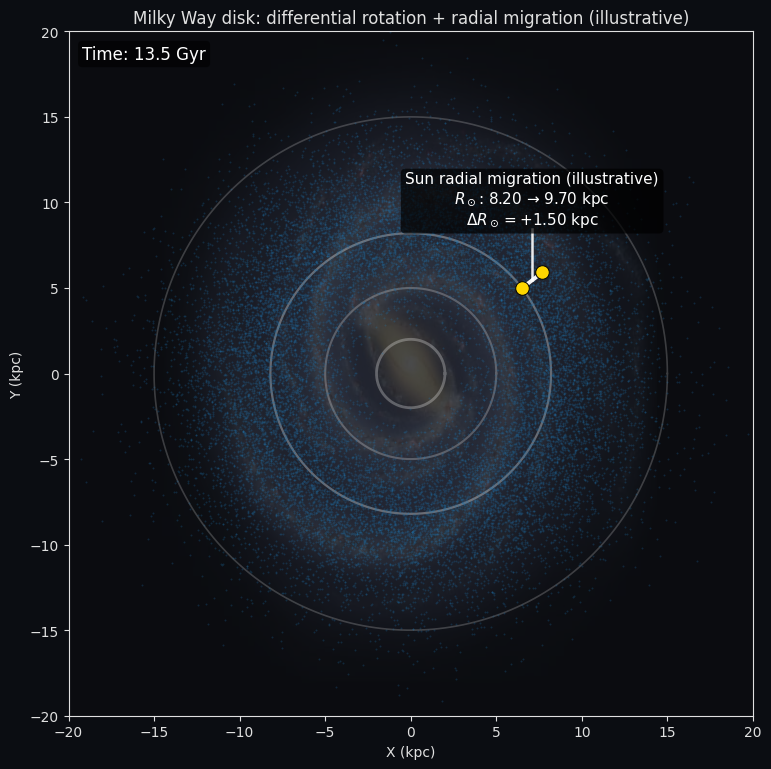

In [37]:
# =========================================================
# ANIM_003 — Face-on disk: rotation + migration (MP4, 30s)
# With Milky Way image as background + simple Sun ΔR line on last frame
# Sun appears at ~9 Gyr, last frame held for ~3 seconds
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.animation import FuncAnimation

# --- project paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

from lulab.anim.defaults import save_animation

# --- background image (put file here) ---
BG_IMG_PATH = topic_root / "assets" / "nasa-milky-way-galaxy.jpg"
BG_ALPHA = 0.25          # 0..1
BG_ZORDER = -50

# --- input dataframe exported earlier ---
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found:\n{csv_path}")

df = pd.read_csv(csv_path)

# ---------------------------------------------------------
# 1) Clean + sample
# ---------------------------------------------------------
df = df.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

N = min(len(df), 20000)
rng = np.random.default_rng(7)
samp = df.sample(N, random_state=7).reset_index(drop=True)

R0 = samp["R_gal"].to_numpy(float)
feh = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N)

# ---------------------------------------------------------
# 2) Physics-ish parametrization
# ---------------------------------------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5

V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR

Omega = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N)
dR_end = np.clip(dR_end, -5.0, 5.0)
dR_end += 0.6 * np.tanh(feh)     # small illustrative bias
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# ---------------------------------------------------------
# 3) Sun track
# ---------------------------------------------------------
SUN_BIRTH_GYR = 9.0   # Sun appears only after this time (~13.5 - 4.6)
Rsun0 = 8.2
phi_sun0 = np.deg2rad(20.0)
Omega_sun = V_KPC_PER_GYR / Rsun0
dR_sun_end = 1.5

# ---------------------------------------------------------
# 4) Animation settings (30 sec, slow rotation) + HOLD last frame
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS = 30
BASE_FRAMES = int(DURATION_SEC * FPS)

HOLD_LAST_SEC = 3.0
HOLD_FRAMES = int(HOLD_LAST_SEC * FPS)

FRAMES = BASE_FRAMES + HOLD_FRAMES

R_MAX = 20.0
lim = R_MAX

PT_SIZE = 2.0
PT_ALPHA = 0.25

ROTATION_SCALE = 0.35
Omega_eff = Omega * ROTATION_SCALE
Omega_sun_eff = Omega_sun * ROTATION_SCALE

# ---------------------------------------------------------
# 5) Figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Milky Way disk: differential rotation + radial migration (illustrative)")

# --- Milky Way background image (behind everything) ---
if BG_IMG_PATH.exists():
    bg = plt.imread(BG_IMG_PATH)
    ax.imshow(
        bg,
        extent=(-lim, lim, -lim, lim),
        origin="lower",
        alpha=BG_ALPHA,
        zorder=BG_ZORDER
    )
else:
    print("Background image not found:", BG_IMG_PATH)

# ring guides (optional but helpful)
theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.28), (5.0, 1.5, 0.24), (8.2, 1.6, 0.32), (15.0, 1.2, 0.20)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color="white", zorder=0)

# stars
sc = ax.scatter([], [], s=PT_SIZE, alpha=PT_ALPHA, linewidths=0, color="tab:blue", zorder=2)

# Sun (moving)
sun_sc = ax.scatter([], [], s=80, marker="o", color="gold",
                    edgecolors="k", linewidths=0.6, zorder=6)

# time label
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# final-frame extras: birth+final Sun markers + simple line + callout
sun_birth_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)
sun_final_sc = ax.scatter([], [], s=95, marker="o", color="gold",
                          edgecolors="k", linewidths=0.7, zorder=9)

# <-- simple straight line between markers (requested)
sun_connector, = ax.plot([], [], lw=2.8, color="white", alpha=0.95, zorder=8)

callout_line,  = ax.plot([], [], lw=1.8, color="white", alpha=0.9, zorder=8)
callout_txt = ax.text(
    np.nan, np.nan, "",
    ha="center", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.70, edgecolor="none"),
    color="white",
    zorder=10
)

# Precompute final-frame Sun radial-only annotation at final azimuth
Rsun_birth = Rsun0
Rsun_final = Rsun0 + dR_sun_end
delta_R = Rsun_final - Rsun_birth

dt_total = (T_END_GYR - T_START_GYR)
phi_sun_final = phi_sun0 + Omega_sun_eff * dt_total

x_birth = Rsun_birth * np.cos(phi_sun_final)
y_birth = Rsun_birth * np.sin(phi_sun_final)
x_final = Rsun_final * np.cos(phi_sun_final)
y_final = Rsun_final * np.sin(phi_sun_final)

# ---------------------------------------------------------
# 6) Animation
# ---------------------------------------------------------
def init():
    sc.set_offsets(np.zeros((0, 2)))
    sun_sc.set_offsets(np.array([[np.nan, np.nan]]))

    sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
    sun_connector.set_data([], [])
    callout_line.set_data([], [])
    callout_txt.set_position((np.nan, np.nan))
    callout_txt.set_text("")
    time_txt.set_text("")
    return []

def update(i):
    # Freeze last frame for HOLD_FRAMES
    if i >= BASE_FRAMES - 1:
        u = 1.0
    else:
        u = i / (BASE_FRAMES - 1)

    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt = (t_gyr - T_START_GYR)

    # stars
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_eff * dt
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    sc.set_offsets(np.column_stack([x, y]))

    time_txt.set_text(f"Time: {t_gyr:4.1f} Gyr")

    # Sun appears only after SUN_BIRTH_GYR
    if t_gyr < SUN_BIRTH_GYR:
        sun_sc.set_offsets(np.array([[np.nan, np.nan]]))
        show_sun = False
    else:
        show_sun = True
        R_sun = Rsun0 + dR_sun_end * e
        phi_sun = phi_sun0 + Omega_sun_eff * dt
        x_sun = R_sun * np.cos(phi_sun)
        y_sun = R_sun * np.sin(phi_sun)
        sun_sc.set_offsets(np.array([[x_sun, y_sun]]))

    # Show final-frame annotation during the whole HOLD segment (if Sun exists)
    if (i >= BASE_FRAMES - 1) and show_sun:
        sun_birth_sc.set_offsets(np.array([[x_birth, y_birth]]))
        sun_final_sc.set_offsets(np.array([[x_final, y_final]]))

        # simple straight line between start/end
        sun_connector.set_data([x_birth, x_final], [y_birth, y_final])

        mx, my = 0.5*(x_birth + x_final), 0.5*(y_birth + y_final)
        LIFT = 3.0
        tx, ty = mx, my + LIFT
        callout_line.set_data([mx, tx], [my, ty])

        callout_txt.set_position((tx, ty))
        callout_txt.set_text(
            "Sun radial migration (illustrative)\n"
            f"$R_\\odot$: {Rsun_birth:.2f} → {Rsun_final:.2f} kpc\n"
            f"$\\Delta R_\\odot = {delta_R:+.2f}\\ \\mathrm{{kpc}}$"
        )
    else:
        sun_birth_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_final_sc.set_offsets(np.array([[np.nan, np.nan]]))
        sun_connector.set_data([], [])
        callout_line.set_data([], [])
        callout_txt.set_position((np.nan, np.nan))
        callout_txt.set_text("")
        
    return []

anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)

# ---------------------------------------------------------
# 7) Save (two lines)
# ---------------------------------------------------------
out = topic_root / "animations" / "ANIM_003_ISM_faceon_rotation_plus_migration_bg"
save_animation(anim, out, fmt="mp4")

plt.show()

### 2.10. Spiral density waves and stars rotating in a galaxy

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_spiral_density_waves.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_002_ISM_spiral_density_waves.gif exists: True


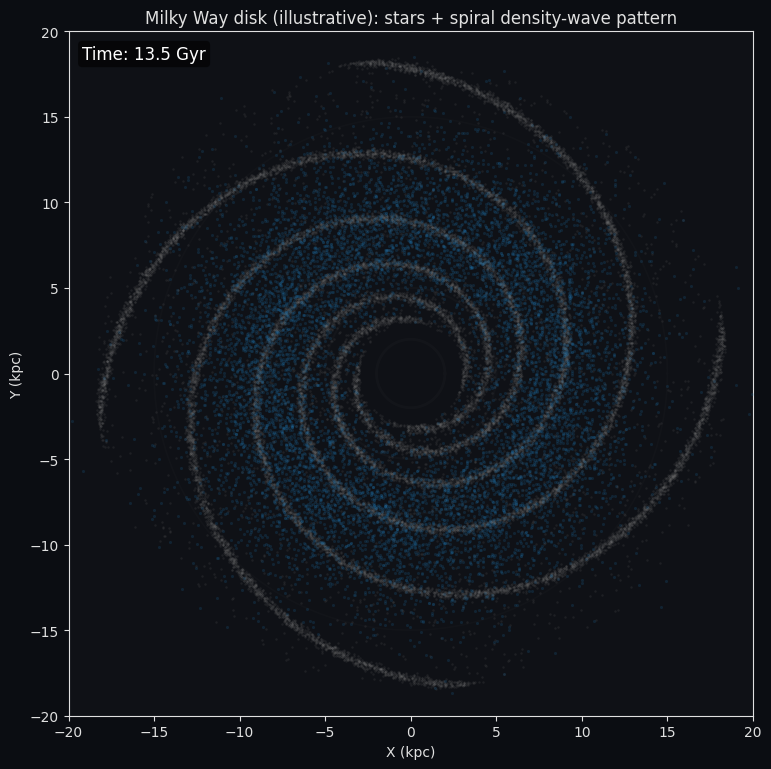

In [41]:
# =========================================================
# ANIM_004 — Face-on disk: clear spiral density waves (NO Sun labels, NO bg image)
# Stars (blue) follow rotation+migration; density-wave tracers (gray) show spiral arms.
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.animation import FuncAnimation

# --- project paths ---
root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent
topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"

from lulab.anim.defaults import save_animation

# --- input dataframe exported earlier ---
csv_path = topic_root / "data/processed/apogee_gaia_ism_proxy.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found:\n{csv_path}")

df = pd.read_csv(csv_path)

# ---------------------------------------------------------
# 1) Stellar component (real data proxy) — fewer points, bigger markers
# ---------------------------------------------------------
df = df.dropna(subset=["R_gal", "feh"]).copy()
df = df[(df["R_gal"] > 0.5) & (df["R_gal"] < 20.0)].copy()

N_STARS = min(len(df), 10000)   # keep light
rng = np.random.default_rng(7)
samp = df.sample(N_STARS, random_state=7).reset_index(drop=True)

R0 = samp["R_gal"].to_numpy(float)
feh = samp["feh"].to_numpy(float)
phi0 = rng.uniform(0, 2*np.pi, size=N_STARS)

# ---------------------------------------------------------
# 2) Gas/density-wave tracers (synthetic) — increase to make waves obvious
# ---------------------------------------------------------
# We draw "gas tracers" that are concentrated around log-spiral arms.
# These tracers DO NOT migrate radially; they primarily rotate with a pattern speed.
N_GAS = 18000                 # raise/lower for performance
N_ARMS = 4                    # Milky Way-ish
PITCH_DEG = 12.5              # pitch angle (bigger => more open arms)
ARM_WIDTH_KPC = 0.65          # thickness of arms (smaller => sharper arms)
R_GAS_MIN, R_GAS_MAX = 3.0, 18.5

pitch = np.deg2rad(PITCH_DEG)
b = 1.0 / np.tan(pitch)       # log-spiral slope in phi(R): phi = b ln(R) + phi0

# base radii and arm assignment
R_gas0 = rng.uniform(R_GAS_MIN, R_GAS_MAX, size=N_GAS)
arm_id = rng.integers(0, N_ARMS, size=N_GAS)

# ideal spiral phase for each arm, then add small phase noise that maps to thickness
phi_arm0 = arm_id * (2*np.pi / N_ARMS) + b * np.log(R_gas0)

# Convert an arm thickness (kpc) into an approximate phase scatter:
# at fixed R, transverse displacement ~ R * dphi, so dphi ~ width / R.
phi_scatter = rng.normal(0.0, ARM_WIDTH_KPC / np.clip(R_gas0, 1.0, None), size=N_GAS)
phi_gas0 = phi_arm0 + phi_scatter

# add a touch of diffuse inter-arm medium for realism (and contrast)
F_INTERARM = 0.15
n_inter = int(F_INTERARM * N_GAS)
if n_inter > 0:
    R_int = rng.uniform(R_GAS_MIN, R_GAS_MAX, size=n_inter)
    phi_int = rng.uniform(0, 2*np.pi, size=n_inter)
    R_gas0 = np.concatenate([R_gas0, R_int])
    phi_gas0 = np.concatenate([phi_gas0, phi_int])

# ---------------------------------------------------------
# 3) Kinematics (stars rotate + migrate; gas rotates with pattern speed)
# ---------------------------------------------------------
T_START_GYR = 3.0
T_END_GYR   = 13.5

# flat rotation curve for stars
V_KMS = 220.0
KMS_TO_KPC_PER_GYR = 1.022712
V_KPC_PER_GYR = V_KMS * KMS_TO_KPC_PER_GYR
Omega_star = V_KPC_PER_GYR / np.clip(R0, 0.8, None)

# migration (keep as before, modest)
sigma_kpc = 2.0
dR_end = rng.normal(0.0, sigma_kpc, size=N_STARS)
dR_end = np.clip(dR_end, -5.0, 5.0)
dR_end += 0.6 * np.tanh(feh)     # illustrative bias
dR_end = np.clip(dR_end, -5.0, 5.0)

def ease_in_out(x):
    return 0.5 - 0.5*np.cos(np.pi*x)

# rotation scaling to keep motion readable
ROTATION_SCALE = 0.25
Omega_star_eff = Omega_star * ROTATION_SCALE

# spiral pattern speed: choose a constant so arms "sweep through" stars
# Typical MW pattern speeds are often quoted ~ 20–30 km/s/kpc.
# Convert km/s/kpc -> rad/Gyr: (km/s to kpc/Gyr) / kpc = 1/Gyr, i.e., rad/Gyr scale.
PATTERN_KMS_PER_KPC = 25.0
Omega_p = PATTERN_KMS_PER_KPC * KMS_TO_KPC_PER_GYR  # ~ 25.6 rad/Gyr? (works as narrative speed)
Omega_p_eff = Omega_p * ROTATION_SCALE

# ---------------------------------------------------------
# 4) Animation settings
# ---------------------------------------------------------
DURATION_SEC = 30.0
FPS = 30
FRAMES = int(DURATION_SEC * FPS)

R_MAX = 20.0
lim = R_MAX

# visual tuning — make arms obvious
STAR_SIZE = 5.0
STAR_ALPHA = 0.18

GAS_SIZE = 3.0
GAS_ALPHA = 0.12
GAS_COLOR = "0.55"  # mid-gray

# ---------------------------------------------------------
# 5) Figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7.6, 7.6), constrained_layout=True)
ax.set_aspect("equal", "box")
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
ax.set_title("Milky Way disk (illustrative): stars + spiral density-wave pattern")

# ring guides (subtle)
theta = np.linspace(0, 2*np.pi, 512)
for rr, lw, a in [(2.0, 2.0, 0.10), (5.0, 1.5, 0.10), (8.2, 1.6, 0.12), (15.0, 1.2, 0.08)]:
    ax.plot(rr*np.cos(theta), rr*np.sin(theta), lw=lw, alpha=a, color="0.25", zorder=0)

# gas tracers (density-wave pattern) — draw FIRST, behind stars
gas_sc = ax.scatter([], [], s=GAS_SIZE, alpha=GAS_ALPHA, linewidths=0, color=GAS_COLOR, zorder=1)

# stars on top
star_sc = ax.scatter([], [], s=STAR_SIZE, alpha=STAR_ALPHA, linewidths=0, color="tab:blue", zorder=3)

# time label (keep, readable)
time_txt = ax.text(
    0.02, 0.98, "",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.60, edgecolor="none"),
    color="white",
    zorder=10
)

# ---------------------------------------------------------
# 6) Animation
# ---------------------------------------------------------
def init():
    gas_sc.set_offsets(np.zeros((0, 2)))
    star_sc.set_offsets(np.zeros((0, 2)))
    time_txt.set_text("")
    return []

def update(i):
    u = i / (FRAMES - 1)
    e = ease_in_out(u)

    t_gyr = T_START_GYR + (T_END_GYR - T_START_GYR) * u
    dt = (t_gyr - T_START_GYR)

    # --- density-wave tracers: rotate with pattern speed (rigid pattern) ---
    phi_g = phi_gas0 + Omega_p_eff * dt
    xg = R_gas0 * np.cos(phi_g)
    yg = R_gas0 * np.sin(phi_g)
    gas_sc.set_offsets(np.column_stack([xg, yg]))

    # --- stars: differential rotation + migration ---
    R = np.clip(R0 + dR_end * e, 0.5, R_MAX)
    phi = phi0 + Omega_star_eff * dt
    xs = R * np.cos(phi)
    ys = R * np.sin(phi)
    star_sc.set_offsets(np.column_stack([xs, ys]))

    time_txt.set_text(f"Time: {t_gyr:4.1f} Gyr")
    return []

anim = FuncAnimation(fig, update, frames=FRAMES, init_func=init, blit=False)

# ---------------------------------------------------------
# 7) Save (two lines)
# ---------------------------------------------------------
out = topic_root / "animations" / "ANIM_002_ISM_spiral_density_waves"
save_animation(anim, out)

plt.show()